## World Compliance - Carbon Tax & ETS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mysql.connector
import config
import folium
import json
import urllib
import urllib.request
import matplotlib.colors as mcolors
import branca.colormap as cm
import re
import matplotlib.ticker as ticker


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}

In [3]:
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [4]:
sql_query = """
SELECT 
    `Name`, 
    `Type`, 
    `Status`,
    `Jurisdiction`,
    `Offset eligibility`
FROM 
    `compliance_info`
"""

In [5]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_19915/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,Name,Type,Status,Jurisdiction,Offset eligibility
0,Poland carbon tax,National Carbon tax,Implemented in 1990,Poland,Not permitted
1,Norway carbon tax,National Carbon tax,Implemented in 1991,Norway,Not permitted
2,Sweden carbon tax,National Carbon tax,Implemented in 1991,Sweden,Not permitted
3,Denmark carbon tax,National Carbon tax,Implemented in 1992,Denmark,Not permitted
4,Alberta TIER,Subnational - State/Province ETS,Implemented in 2007,Alberta,"Yes, with quantitative limit"
...,...,...,...,...,...
112,Mauritania Carbon tax,National Carbon tax,Under consideration since 2024,Mauritania,None
113,Philippines Undecided,National Undecided,Under consideration since 2024,Philippines,None
114,Spain carbon tax,National Carbon tax,Implemented in 2014,Spain,Not permitted
115,South Africa carbon tax,National Carbon tax,Implemented in 2019,South Africa,"Yes, with quantitative limit"


In [6]:
df['Type'].value_counts()

Type
National Carbon tax                        41
National ETS                               28
Subnational - State/Province ETS           22
Subnational - State/Province Carbon tax    13
Subnational - City ETS                      7
National Undecided                          2
Regional ETS                                2
Subnational - State or Province ETS         1
National                                    1
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                117 non-null    object
 1   Type                117 non-null    object
 2   Status              117 non-null    object
 3   Jurisdiction        117 non-null    object
 4   Offset eligibility  102 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [8]:
df['Jurisdiction'].value_counts()

Jurisdiction
Canada                       3
Taiwan                       2
Ukraine                      2
Chile                        2
South Africa                 2
                            ..
Massachusetts                1
Newfoundland and Labrador    1
China                        1
Singapore                    1
Queretaro                    1
Name: count, Length: 102, dtype: int64

In [9]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = df


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Greece', 'Tunisia', 'Haiti', 'Western Sahara', 'North Korea', 'Republic of the Congo', 'Kuwait', 'Somalia', 'Costa Rica', 'Jordan', 'Mozambique', 'The Bahamas', 'New Caledonia', 'Mali', 'Peru', 'Bolivia', 'Bosnia and Herzegovina', 'Ivory Coast', 'Ghana', 'Belize', 'Liberia', 'Djibouti', 'Lithuania', 'South Sudan', 'United Arab Emirates', 'Togo', 'Democratic Republic of the Congo', 'Italy', 'Iran', 'Rwanda', 'United States of America', 'French Southern and Antarctic Lands', 'Suriname', 'Swaziland', 'Yemen', 'Uganda', 'Burundi', 'Georgia', 'Malawi', 'Jamaica', 'Turkey', 'Venezuela', 'Lesotho', 'Nicaragua', 'Kosovo', 'Papua New Guinea', 'Syria', 'Falkland Islands', 'Somaliland', 'Cambodia', 'South Korea', 'Libya', 'Macedonia', 'Qatar', 'Bulgaria', 'Lebanon', 'Gambia', 'Central African Republic', 'Armenia', 'Honduras', 'United Republic of Tanzania', 'Iraq', 'Bangladesh', 'West Bank', 'Afghanistan', 'Equatorial Guinea', 'Puerto Rico', 

In [10]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'New York State': 'United States of America',
    'Tianjin': 'China',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Maryland': 'United States of America',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'San Luis Potosí': 'Mexico',
    'Jalisco': 'Mexico',
    'Sakhalin': 'Russia',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China',
    'Massachusetts': 'United States of America',
    'Saitama': 'Japan',
    'Alberta': 'Canada',
    'EU': None,
    'Hawaii': 'United States of America',
    'Colorado': 'United States of America',
    'Türkiye': 'Turkey',
    'Saskatchewan': 'Canada',
    'Oregon': 'United States of America',
    'Pennsylvania': 'United States of America',
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'Nova Scotia': 'Canada',
    'RGGI': 'United States of America',
    'British Columbia': 'Canada',
    'EU27+': None,
    'Shanghai': 'China',
    'Hubei': 'China',
    'Beijing': 'China',
    'Fujian':'China',
    'California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Côte d’Ivoire': 'Ivory Coast',  # 更新為正式名稱
    'Brunei Darussalam': 'Brunei',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Viet Nam': 'Vietnam',  # 更新為正式名稱
    'Tokyo': 'Japan',
    'Colima': 'Mexico'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)
    

Countries present in Jurisdiction but not in GeoJSON after mapping:
{None, 'Singapore', 'Liechtenstein'}


In [11]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
with urllib.request.urlopen(world_geojson_url) as response:
    world_geojson = json.load(response)

sg_in_geojson = False
for feature in world_geojson['features']:
    if feature['properties']['name'] == 'Singapore':
        sg_in_geojson = True
        break

if sg_in_geojson:
    print('Singapore is in the GeoJSON data.')
else:
    print('Singapore is not in the GeoJSON data.')

li_in_geojson = False
for feature in world_geojson['features']:
    if feature['properties']['name'] == 'Liechtenstein':
        li_in_geojson = True
        break

if li_in_geojson:
    print('Liechtenstein is in the GeoJSON data.')
else:
    print('Liechtenstein is not in the GeoJSON data.')

Singapore is not in the GeoJSON data.
Liechtenstein is not in the GeoJSON data.


In [12]:
# Get unique counts of mechanisms for each country
mechanism_counts = data.groupby('Jurisdiction')['Name'].nunique()

m = folium.Map(location=[0, 0], zoom_start=2, min_zoom=2, max_zoom=10)

# Color mapping palette
sns_palette = sns.color_palette('crest')

# Define the style function
def style_function(feature):
    country_name = feature['properties']['name']
    corrected_country_name = country_name_mapping.get(country_name, country_name)  # Use country name mapping dictionary for correction
    if corrected_country_name in data['Jurisdiction'].values:
        # Get data for the current country
        country_data = data[data['Jurisdiction'] == corrected_country_name]
        # Count the number of mechanisms for the current country
        num_mechanisms = country_data['Name'].nunique()
        # Assign color based on the number of mechanisms
        if num_mechanisms == 0:
            country_color = '#e8dfd8'  # Default color if no mechanisms
        else:
            # Determine the color index based on the percentage of maximum count
            max_count = mechanism_counts.max()
            color_index = int((num_mechanisms / max_count) * (len(sns_palette) - 2))
            country_color = mcolors.rgb2hex(sns_palette[color_index])
    else:
        country_color = '#e8dfd8'  # Default color if country not found in data

    return {
        'fillColor': country_color,
        'fillOpacity': 0.7,
        'weight': 1.0,
        'color': None
    }

# Add GeoJSON layer with tooltips and colours
for feature in world_geojson['features']:
    country_name = feature['properties']['name']
    if country_name in data['Jurisdiction'].values:
        # Get data for the current country
        country_data = data[data['Jurisdiction'] == country_name]
        # Construct tooltip content
        names = "<br>".join(country_data['Name'].tolist())  # Concatenate all names with <br> as separator
        tooltip = folium.Tooltip(f"""
            Country: {country_name}<br>
            Names: {names}<br>
        """)

        folium.GeoJson(
            feature, 
            tooltip=tooltip, 
            style_function=style_function
        ).add_to(m)

# palette
cmap = sns.color_palette('crest', as_cmap=True)

# colormap
colormap = cm.LinearColormap(
    cmap.colors,
    vmin=1, # min=1, not 0(Not Applicable)
    vmax=max(mechanism_counts),
    caption='Mechanism Count'
)


# colormap = cm.LinearColormap(
#     cmap.colors,
#     vmin=1, # min=1, not 0(Not Applicable)
#     vmax=max(country_counts.values()),
#     caption='Mechanism Count'
# )

colormap.add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 30px; width: 180px; height: 80px; 
                 border:2px solid grey; z-index:9999; font-size:11px;
                 background-color:white; opacity: 0.8; padding: 10px;">
     </div>
     '''
m.save('map.html')
m

In [13]:
# 利用country_name_mapping重新命名
df['Jurisdiction'] = df['Jurisdiction'].replace(country_name_mapping)
df

,Name,Type,Status,Jurisdiction,Offset eligibility
0,Poland carbon tax,National Carbon tax,Implemented in 1990,Poland,Not permitted
1,Norway carbon tax,National Carbon tax,Implemented in 1991,Norway,Not permitted
2,Sweden carbon tax,National Carbon tax,Implemented in 1991,Sweden,Not permitted
3,Denmark carbon tax,National Carbon tax,Implemented in 1992,Denmark,Not permitted
4,Alberta TIER,Subnational - State/Province ETS,Implemented in 2007,Canada,"Yes, with quantitative limit"
...,...,...,...,...,...
112,Mauritania Carbon tax,National Carbon tax,Under consideration since 2024,Mauritania,None
113,Philippines Undecided,National Undecided,Under consideration since 2024,Philippines,None
114,Spain carbon tax,National Carbon tax,Implemented in 2014,Spain,Not permitted
115,South Africa carbon tax,National Carbon tax,Implemented in 2019,South Africa,"Yes, with quantitative limit"


In [14]:
df['Jurisdiction'].value_counts()

Jurisdiction
Canada                      15
Mexico                      11
United States of America    10
China                        9
Japan                        4
                            ..
Israel                       1
Malaysia                     1
Pakistan                     1
Russia                       1
Philippines                  1
Name: count, Length: 61, dtype: int64

In [15]:
df['Type'].value_counts()

Type
National Carbon tax                        41
National ETS                               28
Subnational - State/Province ETS           22
Subnational - State/Province Carbon tax    13
Subnational - City ETS                      7
National Undecided                          2
Regional ETS                                2
Subnational - State or Province ETS         1
National                                    1
Name: count, dtype: int64

In [16]:
# 定義函數設定Type
def map_type(row):
    if row['Type'] == 'National Carbon tax':
        return 'National'
    elif row['Type'] == 'National ETS':
        return 'National'
    elif row['Type'] == 'National Undecided':
        return 'National'
    elif row['Type'] == 'National':
        return 'National'
    elif row['Type'] == 'Regional ETS':
        return 'Regional'
    else:
        return 'Subnational'

# 使用 apply 函數創建新的列
df['Category'] = df.apply(map_type, axis=1)
df.tail()

,Name,Type,Status,Jurisdiction,Offset eligibility,Category
112,Mauritania Carbon tax,National Carbon tax,Under consideration since 2024,Mauritania,None,National
113,Philippines Undecided,National Undecided,Under consideration since 2024,Philippines,None,National
114,Spain carbon tax,National Carbon tax,Implemented in 2014,Spain,Not permitted,National
115,South Africa carbon tax,National Carbon tax,Implemented in 2019,South Africa,"Yes, with quantitative limit",National
116,Queretaro carbon tax,Subnational - State/Province Carbon tax,Implemented in 2022,Mexico,"Yes, with quantitative limit",Subnational


In [17]:
df['Status'].value_counts()

Status
Implemented in 2019               9
Implemented in 2013               8
Implemented in 2022               7
Under consideration since 2024    7
Under consideration since 2021    6
Under consideration since 2022    6
Implemented in 2021               6
Implemented in 2008               5
Implemented in 2014               5
Under development since 2016      5
Implemented in 2023               5
Under development since 2024      4
Implemented in 2010               3
Under consideration since 2018    3
Implemented in 2017               3
Under consideration since 2016    3
Under development since 2023      2
Implemented in 1991               2
Implemented in 2024               2
Implemented in 1990               2
Implemented in 2018               2
Implemented in 2016               2
Implemented in 2015               2
Implemented in 2012               2
Implemented in 2011               2
Implemented in 2009               1
Implemented in 2005               1
Implemented in 2004  

In [18]:
# 正則表達式自定函數設定Stats
import re

def find(df):
    pattern = r"Implemented"
    matches = re.findall(pattern, df, re.IGNORECASE)
    return 'Implemented' if matches else 'Under consideration'

# 使用apply函数創建新的列
df['Status_new'] = df['Status'].apply(find)

# 查看结果
df

,Name,Type,Status,Jurisdiction,Offset eligibility,Category,Status_new
0,Poland carbon tax,National Carbon tax,Implemented in 1990,Poland,Not permitted,National,Implemented
1,Norway carbon tax,National Carbon tax,Implemented in 1991,Norway,Not permitted,National,Implemented
2,Sweden carbon tax,National Carbon tax,Implemented in 1991,Sweden,Not permitted,National,Implemented
3,Denmark carbon tax,National Carbon tax,Implemented in 1992,Denmark,Not permitted,National,Implemented
4,Alberta TIER,Subnational - State/Province ETS,Implemented in 2007,Canada,"Yes, with quantitative limit",Subnational,Implemented
...,...,...,...,...,...,...,...
112,Mauritania Carbon tax,National Carbon tax,Under consideration since 2024,Mauritania,None,National,Under consideration
113,Philippines Undecided,National Undecided,Under consideration since 2024,Philippines,None,National,Under consideration
114,Spain carbon tax,National Carbon tax,Implemented in 2014,Spain,Not permitted,National,Implemented
115,South Africa carbon tax,National Carbon tax,Implemented in 2019,South Africa,"Yes, with quantitative limit",National,Implemented


In [19]:
df['Status_new'].value_counts()

Status_new
Implemented            75
Under consideration    42
Name: count, dtype: int64

### 目前全球已經開始實行的合規機制數量為75個（64%），還沒正式上路、仍在計畫中的為42個（36%）

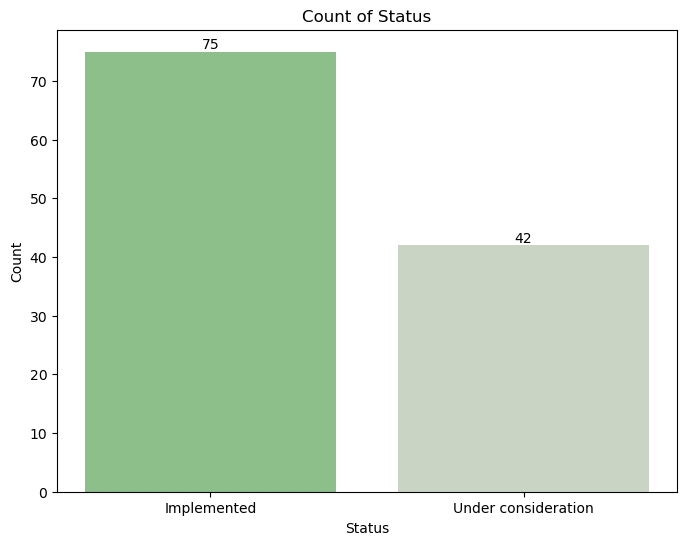

In [20]:
status_data = pd.DataFrame({'Status_new': ['Implemented', 'Under consideration'], 'count': [75, 42]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
bars = plt.bar(status_data['Status_new'], status_data['count'], color=colors)

# 標數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of Status')

plt.show()

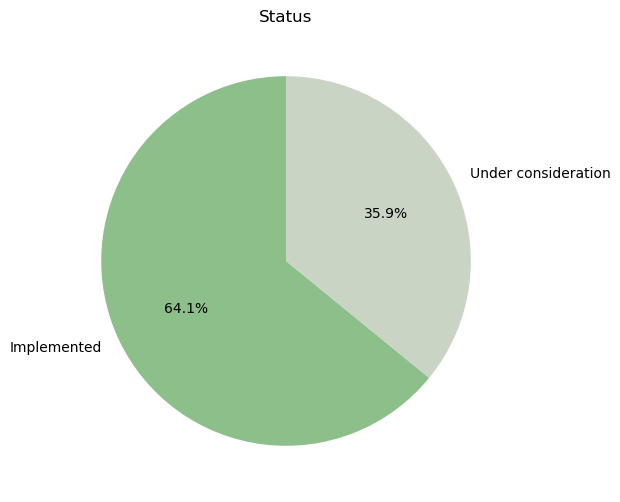

In [21]:
status_data = pd.DataFrame({'Status_new': ['Implemented', 'Under consideration'], 'count': [75, 42]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
plt.pie(status_data['count'], labels=status_data['Status_new'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Status')

plt.show()

In [22]:
# 只留下已實施的國家
df = df[df['Status_new'] == 'Implemented']
df

,Name,Type,Status,Jurisdiction,Offset eligibility,Category,Status_new
0,Poland carbon tax,National Carbon tax,Implemented in 1990,Poland,Not permitted,National,Implemented
1,Norway carbon tax,National Carbon tax,Implemented in 1991,Norway,Not permitted,National,Implemented
2,Sweden carbon tax,National Carbon tax,Implemented in 1991,Sweden,Not permitted,National,Implemented
3,Denmark carbon tax,National Carbon tax,Implemented in 1992,Denmark,Not permitted,National,Implemented
4,Alberta TIER,Subnational - State/Province ETS,Implemented in 2007,Canada,"Yes, with quantitative limit",Subnational,Implemented
...,...,...,...,...,...,...,...
100,Estonia carbon tax,National Carbon tax,Implemented in 2000,Estonia,Not permitted,National,Implemented
105,Austria ETS,National ETS,Implemented in 2022,Austria,Not permitted,National,Implemented
114,Spain carbon tax,National Carbon tax,Implemented in 2014,Spain,Not permitted,National,Implemented
115,South Africa carbon tax,National Carbon tax,Implemented in 2019,South Africa,"Yes, with quantitative limit",National,Implemented


In [23]:
# 分別計算National、Subnational數量
national_counts = df[df['Category'] == 'National'].groupby(['Jurisdiction', 'Status_new']).size()
subnational_counts = df[df['Category'] == 'Subnational'].groupby(['Jurisdiction', 'Status_new']).size()

print(national_counts)
print(subnational_counts)

Jurisdiction    Status_new 
Albania         Implemented    1
Argentina       Implemented    1
Australia       Implemented    1
Austria         Implemented    1
Canada          Implemented    2
Chile           Implemented    1
China           Implemented    1
Colombia        Implemented    1
Denmark         Implemented    1
Estonia         Implemented    1
Finland         Implemented    1
France          Implemented    1
Germany         Implemented    1
Hungary         Implemented    1
Iceland         Implemented    1
Indonesia       Implemented    1
Ireland         Implemented    1
Japan           Implemented    1
Kazakhstan      Implemented    1
Latvia          Implemented    1
Liechtenstein   Implemented    1
Luxembourg      Implemented    1
Mexico          Implemented    2
Montenegro      Implemented    1
Netherlands     Implemented    1
New Zealand     Implemented    1
Norway          Implemented    1
Poland          Implemented    1
Portugal        Implemented    1
Singapore      

### 已實行的機制可以分為國家性（National）、地區性（Subnational）、區域性（Regional）三種，但因為區域性涵蓋的國家超過一個，無法對應到相應國名，所以在這除去歐盟ETS，來細看各國實行中的機制數量如下

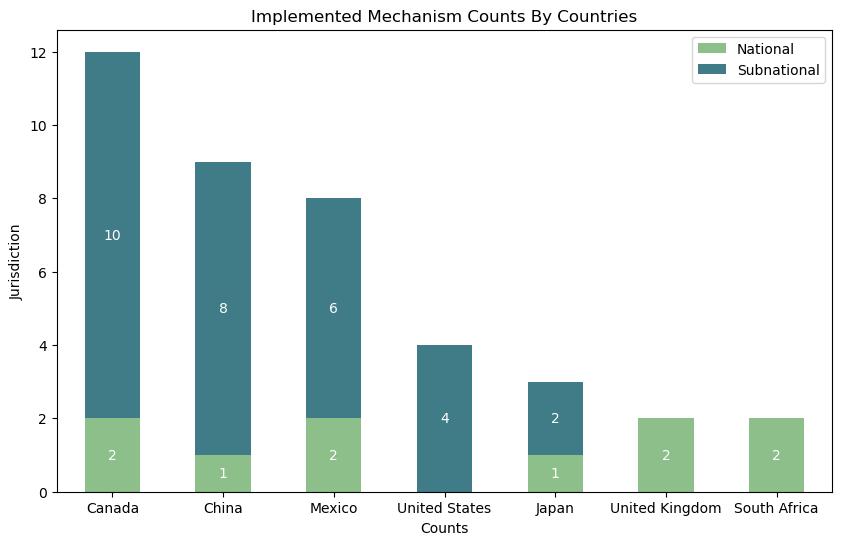

In [24]:
# 合併 National 和 Subnational 資料
merged_counts = pd.concat([national_counts, subnational_counts], axis=1)
merged_counts.columns = ['National', 'Subnational']

# 替換'United States of America'為'United States'
merged_counts.rename(index={'United States of America': 'United States'}, inplace=True)

# 計算每個jurisdiction的總數量並排序
merged_counts['Total'] = merged_counts.sum(axis=1)  # 計算總數量
merged_counts = merged_counts.sort_values(by='Total', ascending=False) 

# 提取索引中的國家名稱作為 x 軸標籤
countries = merged_counts.index.get_level_values(0)[:7]  # 只取值>1

ax = merged_counts.head(7).drop(columns='Total').plot(kind='bar', stacked=True, figsize=(10, 6), color=['#8dbf8b', '#3F7C88'])

for p in ax.patches:
    width = p.get_width()  # width
    height = p.get_height()  # height
    x, y = p.get_xy()  # 起始點座標
    if height > 0: 
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')
        
    
# 設置標籤和標題
plt.xlabel('Counts')
plt.ylabel('Jurisdiction')
plt.title('Implemented Mechanism Counts By Countries')
plt.xticks(range(len(countries)), countries, rotation=0)

# 顯示圖形
plt.show()

---

## Compliance Revenues

In [25]:
sql_query = """
SELECT * FROM `compliance_revenue`
"""

In [26]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_19915/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,Name,Type,Jurisdiction,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Finland carbon tax,Carbon tax,Finland,706.43,644.52,544.66,689.62,936.35,1283.22,1427.17,1137.057,1456,1349.691,1351.745,1609.415,1458.572,1419.493,1644.440,1734.451,1418.644
1,Poland carbon tax,Carbon tax,Poland,1.64,1.12,1.35,1.43,1.41,1.39,1.52,1.223,1.211,1.211,1.142,1.327,1.218,5.936,1.220,6.623,1.258
2,Norway carbon tax,Carbon tax,Norway,1558.54,1206.16,1150.51,1272.46,1278.19,1208,1392.51,1247.205,1500.436,1544.153,1498.542,1812.840,1650.773,1454.774,1759.786,2157.497,1507.941
3,Sweden carbon tax,Carbon tax,Sweden,4200.08,3090.90,3611.36,4323.29,3841.11,3894.80,3725.27,2704.366,3046.353,2809.968,2648.175,2879.056,2492.295,2004.256,2435.323,2342.245,2173.094
4,Denmark carbon tax,Carbon tax,Denmark,1079.26,912.86,913.08,1102.43,1068.29,989.51,1098.51,531.642,567.737,567.737,513.139,600.654,534.249,534.777,496.418,467.831,479.195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Baja California carbon tax,Carbon tax,Baja California,,,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,1.1787,1.2142,Not available
79,Tamaulipas carbon tax,Carbon tax,Tamaulipas,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.8964,0.0000
80,Australia CPM,ETS,Australia,0,0,0,0,0,3415.035,6226.790,2640.369,0,Not available,Not available,Not available,Not available,Not available,Not available,Not available,Not available
81,Alberta carbon tax,Carbon tax,Alberta,0,0,0,0,0,0,0,0,0,Not available,692.7151,1047.1243,1012.9706,Not available,Not available,Not available,Not available


In [27]:
df['Type'].value_counts()

Type
Carbon tax    45
ETS           38
Name: count, dtype: int64

In [28]:
df_tax = df[df['Type'] == 'Carbon tax']
df_tax.head()

,Name,Type,Jurisdiction,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Finland carbon tax,Carbon tax,Finland,706.43,644.52,544.66,689.62,936.35,1283.22,1427.17,1137.057,1456,1349.691,1351.745,1609.415,1458.572,1419.493,1644.440,1734.451,1418.644
1,Poland carbon tax,Carbon tax,Poland,1.64,1.12,1.35,1.43,1.41,1.39,1.52,1.223,1.211,1.211,1.142,1.327,1.218,5.936,1.220,6.623,1.258
2,Norway carbon tax,Carbon tax,Norway,1558.54,1206.16,1150.51,1272.46,1278.19,1208,1392.51,1247.205,1500.436,1544.153,1498.542,1812.840,1650.773,1454.774,1759.786,2157.497,1507.941
3,Sweden carbon tax,Carbon tax,Sweden,4200.08,3090.90,3611.36,4323.29,3841.11,3894.80,3725.27,2704.366,3046.353,2809.968,2648.175,2879.056,2492.295,2004.256,2435.323,2342.245,2173.094
4,Denmark carbon tax,Carbon tax,Denmark,1079.26,912.86,913.08,1102.43,1068.29,989.51,1098.51,531.642,567.737,567.737,513.139,600.654,534.249,534.777,496.418,467.831,479.195


In [29]:
df_ets = df[df['Type'] == 'ETS']
df_ets.head()

,Name,Type,Jurisdiction,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
8,EU ETS,ETS,EU,0,85.57,463.97,1879.39,1295.43,1632.32,4983.43,3407.877,5639.405,4506.722,5906.509,17597.546,16450.445,20992.751,36481.590,42837.663,47369.438
9,Alberta TIER,ETS,Alberta,44.01,69.84,65.81,81.94,63.43,92.16,85.61,66.841,63.923,103.932,101.879,352.077,391.862,301.576,292.280,475.943,638.439
10,Switzerland ETS,ETS,Switzerland,0,0,0,0,0,0,0,8.585,4.967,4.182,4.697,4.639,8.600,7.562,17.124,47.069,39.155
11,New Zealand ETS,ETS,New Zealand,0,0,0,0.36,1.42,1.06,0.00,0.000,0.000,0.001,0.024,0.382,286.944,128.140,1661.478,1405.987,21.787
14,RGGI,ETS,RGGI,0,145.07,349.36,283.08,174.64,167.65,447.97,367.287,435.977,266.466,198.376,239.360,283.989,416.300,926.000,1193.600,1264.941


In [30]:
# transpose year
ts_tax = df_tax.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='tax_Revenue')
ts_tax

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.43
1,Poland carbon tax,Carbon tax,Poland,2007,1.64
2,Norway carbon tax,Carbon tax,Norway,2007,1558.54
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.08
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.26
...,...,...,...,...,...
760,Newfoundland and Labrador carbon tax,Carbon tax,Newfoundland and Labrador,2023,25.8627
761,New Brunswick carbon tax,Carbon tax,New Brunswick,2023,118.2295
762,Baja California carbon tax,Carbon tax,Baja California,2023,Not available
763,Tamaulipas carbon tax,Carbon tax,Tamaulipas,2023,0.0000


In [31]:
# transpose year
ts_ets = df_ets.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='ets_Revenue')
ts_ets

,Name,Type,Jurisdiction,Year,ets_Revenue
0,EU ETS,ETS,EU,2007,0
1,Alberta TIER,ETS,Alberta,2007,44.01
2,Switzerland ETS,ETS,Switzerland,2007,0
3,New Zealand ETS,ETS,New Zealand,2007,0
4,RGGI,ETS,RGGI,2007,0
...,...,...,...,...,...
641,Montenegro ETS,ETS,Montenegro,2023,Not available
642,UK ETS,ETS,United Kingdom,2023,5201.2627
643,Austria ETS,ETS,Austria,2023,917.0888
644,Australia CPM,ETS,Australia,2023,Not available


In [32]:
ts_tax['tax_Revenue'] = pd.to_numeric(ts_tax['tax_Revenue'], errors='coerce')
ts_tax_sum = ts_tax.groupby('Year')['tax_Revenue'].sum().reset_index()

ts_tax_sum['Year'] = pd.to_datetime(ts_tax_sum['Year'], format='%Y')

ts_tax_sum

,Year,tax_Revenue
0,2007-01-01,7615.3200
1,2008-01-01,6241.4329
2,2009-01-01,7002.8354
3,2010-01-01,9136.8813
4,2011-01-01,9070.1887
5,2012-01-01,10013.4061
6,2013-01-01,12179.3825
7,2014-01-01,12103.4399
8,2015-01-01,16580.1280
9,2016-01-01,17623.0457


In [33]:
ts_ets['ets_Revenue'] = pd.to_numeric(ts_ets['ets_Revenue'], errors='coerce')
ts_ets_sum = ts_ets.groupby('Year')['ets_Revenue'].sum().reset_index()

ts_ets_sum['Year'] = pd.to_datetime(ts_ets_sum['Year'], format='%Y')

ts_ets_sum

,Year,ets_Revenue
0,2007-01-01,44.0100
1,2008-01-01,300.4800
2,2009-01-01,879.1400
3,2010-01-01,2244.7700
4,2011-01-01,1534.9200
5,2012-01-01,5363.9850
6,2013-01-01,12249.8700
7,2014-01-01,7058.8190
8,2015-01-01,9359.2120
9,2016-01-01,6042.1756


In [34]:
ts_tax_sum.set_index('Year', inplace=True)
ts_ets_sum.set_index('Year', inplace=True)

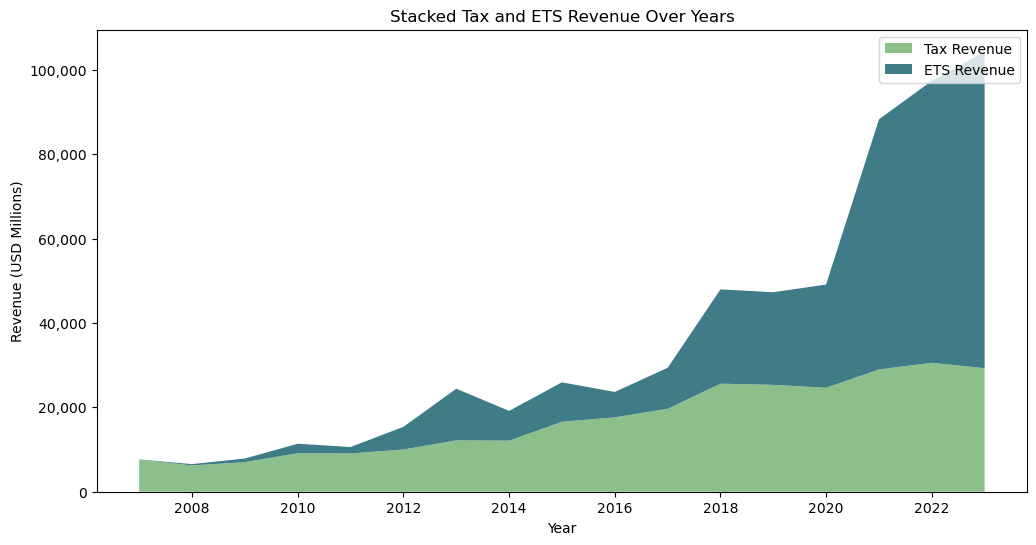

In [35]:
plt.figure(figsize=(12, 6))

colors = ['#8dbf8b', '#3F7C88']

tax_revenue_values = ts_tax_sum['tax_Revenue']
ets_revenue_values = ts_ets_sum['ets_Revenue']

years = ts_tax_sum.index

plt.stackplot(years, tax_revenue_values, ets_revenue_values, labels=['Tax Revenue', 'ETS Revenue'], colors=colors)

plt.title('Stacked Tax and ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')

plt.legend()

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

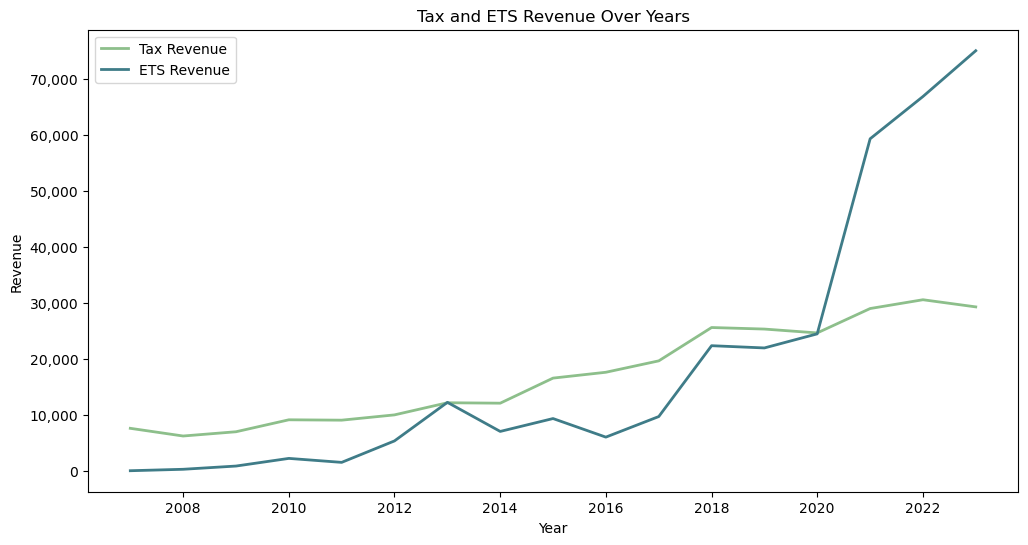

In [36]:
plt.figure(figsize=(12, 6))

colors = ['#8dbf8b', '#3F7C88']

sns.lineplot(data=ts_tax_sum, x=ts_tax_sum.index, y='tax_Revenue', label='Tax Revenue', linewidth=2, color=colors[0])
sns.lineplot(data=ts_ets_sum, x=ts_ets_sum.index, y='ets_Revenue', label='ETS Revenue', linewidth=2, color=colors[1])

plt.title('Tax and ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue')

plt.legend()

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 依照「機制」分別看Tax、ETS排名

In [37]:
ts_tax

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
1,Poland carbon tax,Carbon tax,Poland,2007,1.6400
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
...,...,...,...,...,...
760,Newfoundland and Labrador carbon tax,Carbon tax,Newfoundland and Labrador,2023,25.8627
761,New Brunswick carbon tax,Carbon tax,New Brunswick,2023,118.2295
762,Baja California carbon tax,Carbon tax,Baja California,2023,NaN
763,Tamaulipas carbon tax,Carbon tax,Tamaulipas,2023,0.0000


In [38]:
# Group by 'Name'並計算各年度revenues加總
tax_total_revenue = ts_tax.groupby('Name')['tax_Revenue'].sum()
tax_top_10 = tax_total_revenue.sort_values(ascending=False).head(10)

tax_top_10

Name
France carbon tax             67440.7580
Sweden carbon tax             52221.9410
Norway carbon tax             25200.3170
Japan carbon tax              21685.1460
Canada federal fuel charge    20864.6169
Finland carbon tax            20811.4780
BC carbon tax                 17616.6590
Switzerland carbon tax        14337.9130
UK Carbon Price Support       13753.2120
Denmark carbon tax            12457.3190
Name: tax_Revenue, dtype: float64

In [39]:
ts_tax_top = ts_tax[ts_tax['Name'].isin(['Sweden carbon tax','France carbon tax', 'Norway carbon tax', 'Finland carbon tax', 'Japan carbon tax',
                                         'Canada federal fuel charge', 'BC carbon tax', 'Denmark carbon tax', 'Switzerland carbon tax', 'UK Carbon Price Support'])]
ts_tax_top

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
8,Switzerland carbon tax,Carbon tax,Switzerland,2007,0.0000
...,...,...,...,...,...
729,BC carbon tax,Carbon tax,British Columbia,2023,1958.1760
732,Japan carbon tax,Carbon tax,Japan,2023,1673.1570
733,UK Carbon Price Support,Carbon tax,United Kingdom,2023,994.4950
734,France carbon tax,Carbon tax,France,2023,8373.7500


In [40]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_data = ts_tax_top.pivot_table(index='Year', columns='Name', values='tax_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_data.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_data = pivot_data[sorted_columns]
sorted_pivot_data

Name,France carbon tax,Canada federal fuel charge,Sweden carbon tax,BC carbon tax,Japan carbon tax,Norway carbon tax,Finland carbon tax,Switzerland carbon tax,UK Carbon Price Support,Denmark carbon tax
Year,,,,,,,,,,
2007,0.000,0.0000,4200.080,0.000,0.000,1558.540,706.430,0.000,0.000,1079.260
2008,0.000,0.0000,3090.900,145.220,0.000,1206.160,644.520,191.970,0.000,912.860
2009,0.000,0.0000,3611.360,524.960,0.000,1150.510,544.660,206.210,0.000,913.080
2010,0.000,0.0000,4323.290,717.880,0.000,1272.460,689.620,638.340,0.000,1102.430
2011,0.000,0.0000,3841.110,912.070,0.000,1278.190,936.350,551.680,0.000,1068.290
2012,0.000,0.0000,3894.800,1062.010,416.440,1208.000,1283.220,586.070,0.000,989.510
2013,0.000,0.0000,3725.270,1085.060,871.500,1392.510,1427.170,734.910,1117.160,1098.510
2014,322.650,0.0000,2704.366,954.646,1417.260,1247.205,1137.057,781.702,1765.490,531.642
2015,2858.000,0.0000,3046.353,932.015,1558.530,1500.436,1456.000,881.034,2600.052,567.737


<Figure size 1200x600 with 0 Axes>

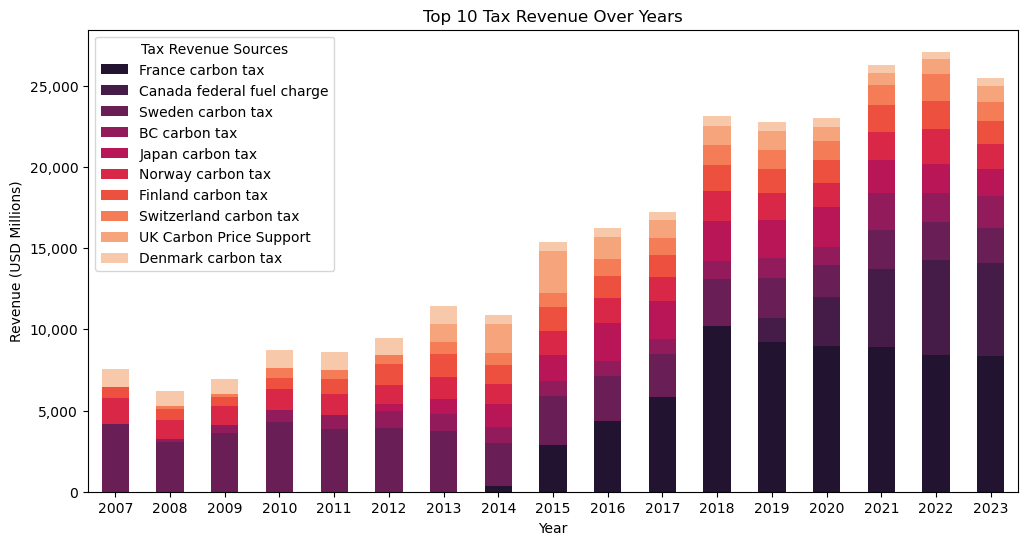

In [41]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_data.columns))

ax = sorted_pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Tax Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [42]:
ts_ets

,Name,Type,Jurisdiction,Year,ets_Revenue
0,EU ETS,ETS,EU,2007,0.0000
1,Alberta TIER,ETS,Alberta,2007,44.0100
2,Switzerland ETS,ETS,Switzerland,2007,0.0000
3,New Zealand ETS,ETS,New Zealand,2007,0.0000
4,RGGI,ETS,RGGI,2007,0.0000
...,...,...,...,...,...
641,Montenegro ETS,ETS,Montenegro,2023,NaN
642,UK ETS,ETS,United Kingdom,2023,5201.2627
643,Austria ETS,ETS,Austria,2023,917.0888
644,Australia CPM,ETS,Australia,2023,NaN


In [43]:
# Group by 'Name'並計算各年度revenues加總
ets_total_revenue = ts_ets.groupby('Name')['ets_Revenue'].sum()
ets_top_10 = ets_total_revenue.sort_values(ascending=False).head(10)

ets_top_10

Name
EU ETS             211530.0560
Germany ETS         27194.4865
California CaT      26976.4240
UK ETS              19199.5323
Australia CPM       12282.1940
RGGI                 7160.0660
Quebec CaT           6021.5610
New Zealand ETS      3507.5830
Alberta TIER         3291.5520
Ontario CaT          2205.6074
Name: ets_Revenue, dtype: float64

In [44]:
ts_ets_top = ts_ets[ts_ets['Name'].isin(['EU ETS', 'Germany ETS', 'California CaT', 'UK ETS', 'Australia CPM',
                                        'RGGI', 'Quebec CaT', 'New Zealand ETS', 'Alberta TIER', 'Ontario CaT'])]
ts_ets_top

,Name,Type,Jurisdiction,Year,ets_Revenue
0,EU ETS,ETS,EU,2007,0.0000
1,Alberta TIER,ETS,Alberta,2007,44.0100
3,New Zealand ETS,ETS,New Zealand,2007,0.0000
4,RGGI,ETS,RGGI,2007,0.0000
7,California CaT,ETS,California,2007,0.0000
...,...,...,...,...,...
616,Quebec CaT,ETS,Quebec,2023,1048.8030
640,Germany ETS,ETS,Germany,2023,11679.8712
642,UK ETS,ETS,United Kingdom,2023,5201.2627
644,Australia CPM,ETS,Australia,2023,NaN


In [45]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_data = ts_ets_top.pivot_table(index='Year', columns='Name', values='ets_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_data.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_data = pivot_data[sorted_columns]
sorted_pivot_data

Name,EU ETS,Germany ETS,UK ETS,California CaT,RGGI,Quebec CaT,Alberta TIER,New Zealand ETS,Australia CPM,Ontario CaT
Year,,,,,,,,,,
2007,0.000,0.0000,0.0000,0.000,0.000,0.000,44.010,0.000,0.000,0.0000
2008,85.570,0.0000,0.0000,0.000,145.070,0.000,69.840,0.000,0.000,0.0000
2009,463.970,0.0000,0.0000,0.000,349.360,0.000,65.810,0.000,0.000,0.0000
2010,1879.390,0.0000,0.0000,0.000,283.080,0.000,81.940,0.360,0.000,0.0000
2011,1295.430,0.0000,0.0000,0.000,174.640,0.000,63.430,1.420,0.000,0.0000
2012,1632.320,0.0000,0.0000,55.760,167.650,0.000,92.160,1.060,3415.035,0.0000
2013,4983.430,0.0000,0.0000,476.800,447.970,0.000,85.610,0.000,6226.790,0.0000
2014,3407.877,0.0000,0.0000,437.110,367.287,30.800,66.841,0.000,2640.369,0.0000
2015,5639.405,0.0000,0.0000,2558.160,435.977,651.100,63.923,0.000,0.000,0.0000


<Figure size 1200x600 with 0 Axes>

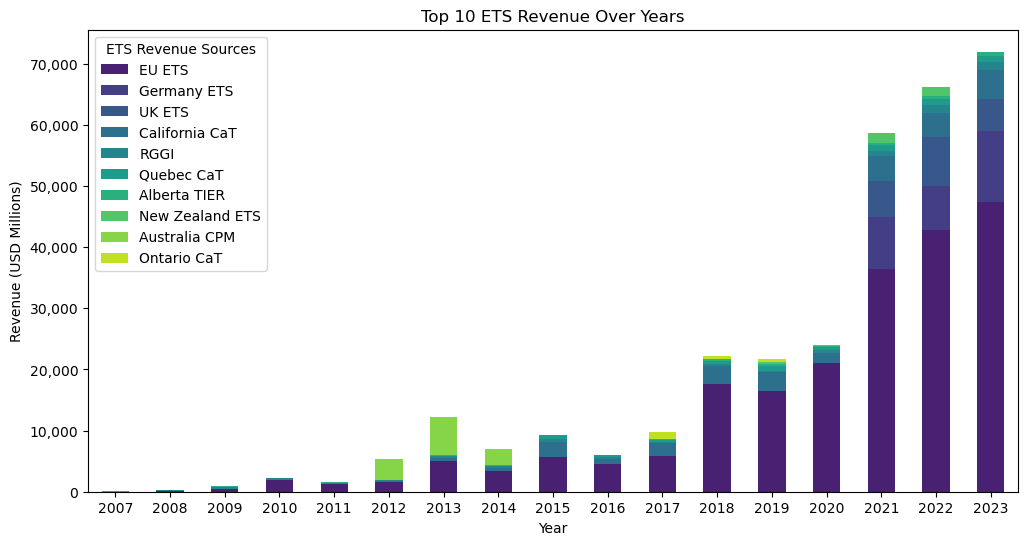

In [46]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_data.columns))

ax = sorted_pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='ETS Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 依照各國分別看Tax、ETS收益排名

In [47]:
ts_tax

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
1,Poland carbon tax,Carbon tax,Poland,2007,1.6400
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
...,...,...,...,...,...
760,Newfoundland and Labrador carbon tax,Carbon tax,Newfoundland and Labrador,2023,25.8627
761,New Brunswick carbon tax,Carbon tax,New Brunswick,2023,118.2295
762,Baja California carbon tax,Carbon tax,Baja California,2023,NaN
763,Tamaulipas carbon tax,Carbon tax,Tamaulipas,2023,0.0000


In [48]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts_tax


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Pakistan', 'India', 'Greece', 'New Zealand', 'Australia', 'Tunisia', 'Mauritania', 'Haiti', 'Philippines', 'Western Sahara', 'North Korea', 'Republic of the Congo', 'Kuwait', 'Somalia', 'Costa Rica', 'Jordan', 'Mozambique', 'The Bahamas', 'New Caledonia', 'Mali', 'Peru', 'Bolivia', 'Bosnia and Herzegovina', 'Ivory Coast', 'Ghana', 'Belize', 'Liberia', 'Djibouti', 'Lithuania', 'Thailand', 'South Sudan', 'United Arab Emirates', 'Togo', 'Democratic Republic of the Congo', 'Italy', 'Iran', 'Rwanda', 'United States of America', 'French Southern and Antarctic Lands', 'Suriname', 'Montenegro', 'Swaziland', 'Yemen', 'Uganda', 'Burundi', 'Georgia', 'Malawi', 'Jamaica', 'Turkey', 'Venezuela', 'Lesotho', 'Nicaragua', 'Kosovo', 'Papua New Guinea', 'Syria', 'Falkland Islands', 'Somaliland', 'Kenya', 'Cambodia', 'South Korea', 'Libya', 'Macedonia', 'Qatar', 'Bulgaria', 'Lebanon', 'Gambia', 'Central African Republic', 'Armenia', 'Honduras', 'Uni

In [49]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'Tamaulipas': 'Mexico',
    'Taiwan, China': 'Taiwan',
    'Prince Edward Island': 'Canada',
    'New York State': 'United States of America',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'Alberta': 'Canada',
    'EU': None,
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'British Columbia': 'Canada',
    'Baja California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Colima': 'Mexico'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)


Countries present in Jurisdiction but not in GeoJSON after mapping:
{'Singapore', 'Liechtenstein'}


In [50]:
# 利用country_name_mapping重新命名
ts_tax['Jurisdiction'] = ts_tax['Jurisdiction'].replace(country_name_mapping)
ts_tax

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
1,Poland carbon tax,Carbon tax,Poland,2007,1.6400
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
...,...,...,...,...,...
760,Newfoundland and Labrador carbon tax,Carbon tax,Canada,2023,25.8627
761,New Brunswick carbon tax,Carbon tax,Canada,2023,118.2295
762,Baja California carbon tax,Carbon tax,United States of America,2023,NaN
763,Tamaulipas carbon tax,Carbon tax,Mexico,2023,0.0000


In [51]:
# Group by 'Name'並計算各年度revenues加總
tax_total_revenue = ts_tax.groupby('Jurisdiction')['tax_Revenue'].sum()
tax_top_10 = tax_total_revenue.sort_values(ascending=False).head(10)

tax_top_10

Jurisdiction
France            67440.7580
Sweden            52221.9410
Canada            42139.3151
Norway            25200.3170
Japan             21685.1460
Finland           20811.4780
Switzerland       14337.9130
United Kingdom    13753.2120
Denmark           12457.3190
Ireland            7546.0385
Name: tax_Revenue, dtype: float64

In [52]:
ts_tax_top = ts_tax[ts_tax['Jurisdiction'].isin(['Sweden', 'France', 'Canada', 'Norway', 'Finland', 
                                                 'Japan', 'Denmark', 'Switzerland', 'United Kingdom', 'Ireland'])]
ts_tax_top

,Name,Type,Jurisdiction,Year,tax_Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
8,Switzerland carbon tax,Carbon tax,Switzerland,2007,0.0000
...,...,...,...,...,...
744,Canada federal fuel charge,Carbon tax,Canada,2023,5719.3527
759,Prince Edward Island Carbon tax,Carbon tax,Canada,2023,10.3451
760,Newfoundland and Labrador carbon tax,Carbon tax,Canada,2023,25.8627
761,New Brunswick carbon tax,Carbon tax,Canada,2023,118.2295


In [53]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_tax = ts_tax_top.pivot_table(index='Year', columns='Jurisdiction', values='tax_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_tax.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_tax = pivot_tax[sorted_columns]
sorted_pivot_tax

Jurisdiction,France,Canada,Sweden,Japan,Norway,Finland,Switzerland,Ireland,United Kingdom,Denmark
Year,,,,,,,,,,
2007,0.000,0.0000,4200.080,0.000,1558.540,706.430,0.000,0.0000,0.000,1079.260
2008,0.000,145.2200,3090.900,0.000,1206.160,644.520,191.970,0.0000,0.000,912.860
2009,0.000,524.9600,3611.360,0.000,1150.510,544.660,206.210,0.0000,0.000,913.080
2010,0.000,717.8800,4323.290,0.000,1272.460,689.620,638.340,313.9300,0.000,1102.430
2011,0.000,912.0700,3841.110,0.000,1278.190,936.350,551.680,398.2400,0.000,1068.290
2012,0.000,1062.0100,3894.800,416.440,1208.000,1283.220,586.070,455.8200,0.000,989.510
2013,0.000,1085.0600,3725.270,871.500,1392.510,1427.170,734.910,535.0500,1117.160,1098.510
2014,322.650,954.6460,2704.366,1417.260,1247.205,1137.057,781.702,414.0675,1765.490,531.642
2015,2858.000,932.0150,3046.353,1558.530,1500.436,1456.000,881.034,474.4280,2600.052,567.737


<Figure size 1200x600 with 0 Axes>

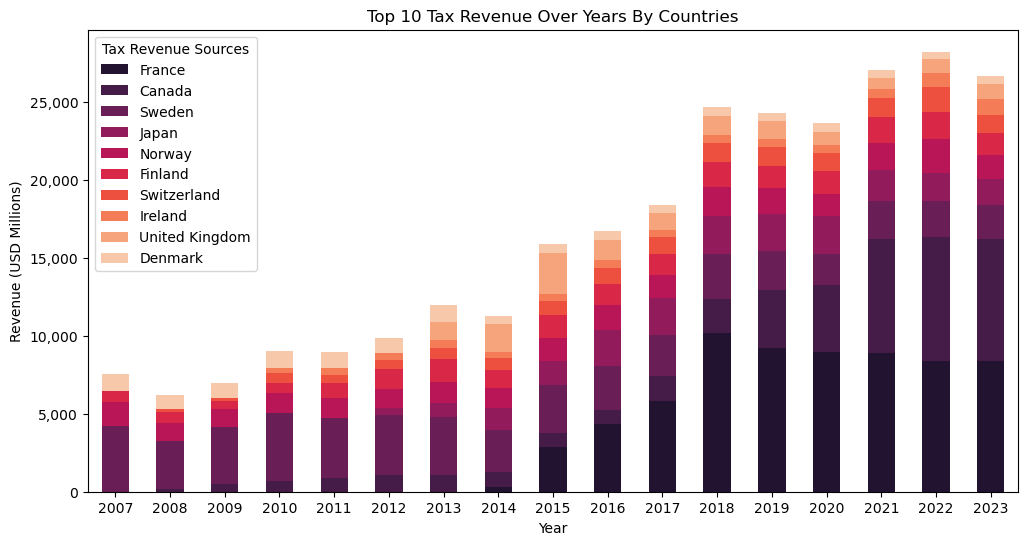

In [54]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_tax.columns))

ax = sorted_pivot_tax.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Tax Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [55]:
ts_ets

,Name,Type,Jurisdiction,Year,ets_Revenue
0,EU ETS,ETS,EU,2007,0.0000
1,Alberta TIER,ETS,Alberta,2007,44.0100
2,Switzerland ETS,ETS,Switzerland,2007,0.0000
3,New Zealand ETS,ETS,New Zealand,2007,0.0000
4,RGGI,ETS,RGGI,2007,0.0000
...,...,...,...,...,...
641,Montenegro ETS,ETS,Montenegro,2023,NaN
642,UK ETS,ETS,United Kingdom,2023,5201.2627
643,Austria ETS,ETS,Austria,2023,917.0888
644,Australia CPM,ETS,Australia,2023,NaN


In [56]:
ts_ets['Jurisdiction'].value_counts()

Jurisdiction
Australia                      34
Ontario                        34
Massachusetts                  17
Washington                     17
Fujian                         17
Canada                         17
China                          17
Mexico                         17
Newfoundland and Labrador      17
EU                             17
Alberta                        17
Saskatchewan                   17
New Brunswick                  17
Indonesia                      17
Germany                        17
Montenegro                     17
United Kingdom                 17
Nova Scotia                    17
British Columbia               17
Korea, Rep.                    17
Quebec                         17
Switzerland                    17
New Zealand                    17
RGGI                           17
Tokyo                          17
Saitama                        17
California                     17
Kazakhstan                     17
Chongqing                      17
S

In [57]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts_ets


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print('Countries present in GeoJSON but not in Jurisdiction:')
print(missing_countries_in_jurisdiction)

print('\nCountries present in Jurisdiction but not in GeoJSON:')
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Pakistan', 'India', 'Greece', 'Tunisia', 'Mauritania', 'Haiti', 'Philippines', 'Western Sahara', 'North Korea', 'Republic of the Congo', 'Kuwait', 'Somalia', 'Costa Rica', 'Ireland', 'The Bahamas', 'Jordan', 'Mozambique', 'New Caledonia', 'Mali', 'Slovenia', 'Peru', 'Bolivia', 'France', 'Bosnia and Herzegovina', 'Ivory Coast', 'Ghana', 'Sweden', 'Belize', 'Uruguay', 'Chile', 'Liberia', 'Djibouti', 'Lithuania', 'Thailand', 'South Sudan', 'Norway', 'United Arab Emirates', 'Togo', 'Democratic Republic of the Congo', 'Italy', 'Iran', 'South Africa', 'Rwanda', 'United States of America', 'French Southern and Antarctic Lands', 'Suriname', 'Swaziland', 'Yemen', 'Albania', 'Uganda', 'Burundi', 'Georgia', 'Malawi', 'Jamaica', 'Turkey', 'Latvia', 'Venezuela', 'Ukraine', 'Lesotho', 'Nicaragua', 'Kosovo', 'Papua New Guinea', 'Syria', 'Falkland Islands', 'Somaliland', 'Kenya', 'Cambodia', 'South Korea', 'Libya', 'Denmark', 'Macedonia', 'Bulgar

In [58]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {    
    'Ontario': 'Canada',
    'Shanghai': 'China',
    'Tianjin': 'China',
    'Korea, Rep.': 'South Korea',
    'Newfoundland and Labrador': 'Canada',
    'Massachusetts': 'United States of America',
    'Washington': 'United States of America',
    'Hubei': 'China',
    'Quebec': 'Canada',
    'New Brunswick': 'Canada',
    'Fujian': 'China',
    'British Columbia': 'Canada',
    'EU': None,
    'California': 'United States of America',
    'Nova Scotia': 'Canada',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China', 
    'Saitama': 'Japan',
    'Saskatchewan': 'Canada',
    'Alberta': 'Canada',
     'Beijing': 'China',
    'RGGI': 'United States of America',
    'Shenzhen': 'China',
    'Tokyo': 'Japan'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)


Countries present in Jurisdiction but not in GeoJSON after mapping:
{None}


In [59]:
# 利用country_name_mapping重新命名
ts_ets['Jurisdiction'] = ts_ets['Jurisdiction'].replace(country_name_mapping)
ts_ets

,Name,Type,Jurisdiction,Year,ets_Revenue
0,EU ETS,ETS,None,2007,0.0000
1,Alberta TIER,ETS,Canada,2007,44.0100
2,Switzerland ETS,ETS,Switzerland,2007,0.0000
3,New Zealand ETS,ETS,New Zealand,2007,0.0000
4,RGGI,ETS,United States of America,2007,0.0000
...,...,...,...,...,...
641,Montenegro ETS,ETS,Montenegro,2023,NaN
642,UK ETS,ETS,United Kingdom,2023,5201.2627
643,Austria ETS,ETS,Austria,2023,917.0888
644,Australia CPM,ETS,Australia,2023,NaN


In [60]:
# Group by 'Name'並計算各年度revenues加總
ets_total_revenue = ts_ets.groupby('Jurisdiction')['ets_Revenue'].sum()
ets_top_10 = ets_total_revenue.sort_values(ascending=False).head(10)

ets_top_10

Jurisdiction
United States of America    36127.4452
Germany                     27194.4865
United Kingdom              19199.5323
Canada                      12294.9925
Australia                   12282.1940
New Zealand                  3507.5830
South Korea                  1080.5980
Austria                       917.0888
China                         526.3574
Switzerland                   146.5800
Name: ets_Revenue, dtype: float64

In [61]:
ts_ets_top = ts_ets[ts_ets['Jurisdiction'].isin(['United States of America',  'Germany', 'United Kingdom', 'Canada', 'Australia',
                                                 'New Zealand', 'South Korea', 'Austria', 'China', 'Switzerland'])]
    
ts_ets_top

,Name,Type,Jurisdiction,Year,ets_Revenue
1,Alberta TIER,ETS,Canada,2007,44.0100
2,Switzerland ETS,ETS,Switzerland,2007,0.0000
3,New Zealand ETS,ETS,New Zealand,2007,0.0000
4,RGGI,ETS,United States of America,2007,0.0000
7,California CaT,ETS,United States of America,2007,0.0000
...,...,...,...,...,...
640,Germany ETS,ETS,Germany,2023,11679.8712
642,UK ETS,ETS,United Kingdom,2023,5201.2627
643,Austria ETS,ETS,Austria,2023,917.0888
644,Australia CPM,ETS,Australia,2023,NaN


In [62]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ets = ts_ets_top.pivot_table(index='Year', columns='Jurisdiction', values='ets_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_ets.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ets = pivot_ets[sorted_columns]
sorted_pivot_ets

Jurisdiction,Germany,United States of America,United Kingdom,Canada,Austria,South Korea,China,Switzerland,New Zealand,Australia
Year,,,,,,,,,,
2007,0.0000,0.0000,0.0000,44.0100,0.0000,0.000,0.0000,0.000,0.000,0.000
2008,0.0000,145.0700,0.0000,69.8400,0.0000,0.000,0.0000,0.000,0.000,0.000
2009,0.0000,349.3600,0.0000,65.8100,0.0000,0.000,0.0000,0.000,0.000,0.000
2010,0.0000,283.0800,0.0000,81.9400,0.0000,0.000,0.0000,0.000,0.360,0.000
2011,0.0000,174.6400,0.0000,63.4300,0.0000,0.000,0.0000,0.000,1.420,0.000
2012,0.0000,223.4100,0.0000,92.1600,0.0000,0.000,0.0000,0.000,1.060,3415.035
2013,0.0000,924.7700,0.0000,85.6100,0.0000,0.000,29.2700,0.000,0.000,6226.790
2014,0.0000,804.3970,0.0000,97.6410,0.0000,0.000,99.9500,8.585,0.000,2640.369
2015,0.0000,2994.1370,0.0000,715.0230,0.0000,0.000,5.6800,4.967,0.000,0.000


<Figure size 1200x600 with 0 Axes>

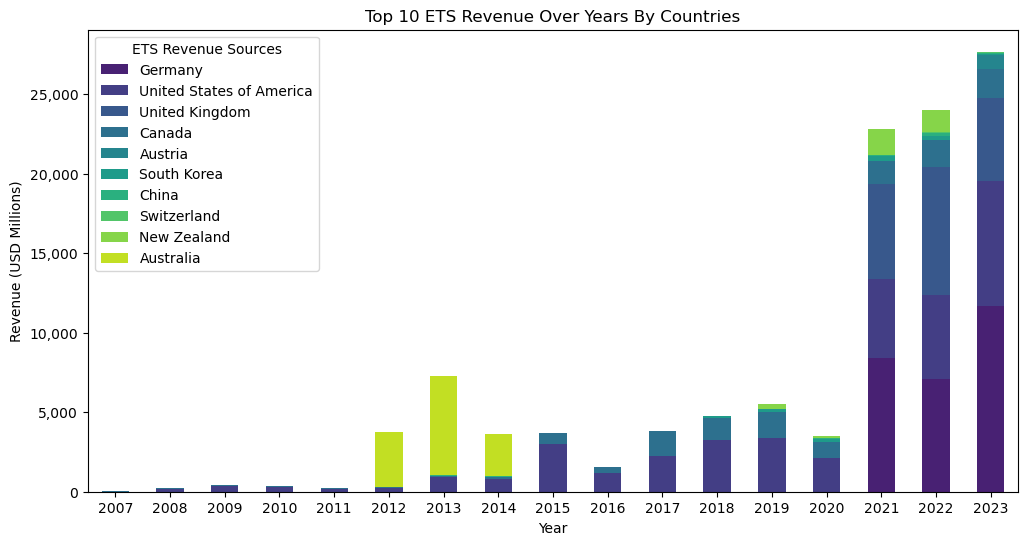

In [63]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_ets.columns))

ax = sorted_pivot_ets.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 ETS Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='ETS Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 將Tax & ETS依照國家看總和排名

In [64]:
df

,Name,Type,Jurisdiction,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Finland carbon tax,Carbon tax,Finland,706.43,644.52,544.66,689.62,936.35,1283.22,1427.17,1137.057,1456,1349.691,1351.745,1609.415,1458.572,1419.493,1644.440,1734.451,1418.644
1,Poland carbon tax,Carbon tax,Poland,1.64,1.12,1.35,1.43,1.41,1.39,1.52,1.223,1.211,1.211,1.142,1.327,1.218,5.936,1.220,6.623,1.258
2,Norway carbon tax,Carbon tax,Norway,1558.54,1206.16,1150.51,1272.46,1278.19,1208,1392.51,1247.205,1500.436,1544.153,1498.542,1812.840,1650.773,1454.774,1759.786,2157.497,1507.941
3,Sweden carbon tax,Carbon tax,Sweden,4200.08,3090.90,3611.36,4323.29,3841.11,3894.80,3725.27,2704.366,3046.353,2809.968,2648.175,2879.056,2492.295,2004.256,2435.323,2342.245,2173.094
4,Denmark carbon tax,Carbon tax,Denmark,1079.26,912.86,913.08,1102.43,1068.29,989.51,1098.51,531.642,567.737,567.737,513.139,600.654,534.249,534.777,496.418,467.831,479.195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Baja California carbon tax,Carbon tax,Baja California,,,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,1.1787,1.2142,Not available
79,Tamaulipas carbon tax,Carbon tax,Tamaulipas,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.8964,0.0000
80,Australia CPM,ETS,Australia,0,0,0,0,0,3415.035,6226.790,2640.369,0,Not available,Not available,Not available,Not available,Not available,Not available,Not available,Not available
81,Alberta carbon tax,Carbon tax,Alberta,0,0,0,0,0,0,0,0,0,Not available,692.7151,1047.1243,1012.9706,Not available,Not available,Not available,Not available


In [65]:
ts = df.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='Revenue')
ts

,Name,Type,Jurisdiction,Year,Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.43
1,Poland carbon tax,Carbon tax,Poland,2007,1.64
2,Norway carbon tax,Carbon tax,Norway,2007,1558.54
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.08
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.26
...,...,...,...,...,...
1406,Baja California carbon tax,Carbon tax,Baja California,2023,Not available
1407,Tamaulipas carbon tax,Carbon tax,Tamaulipas,2023,0.0000
1408,Australia CPM,ETS,Australia,2023,Not available
1409,Alberta carbon tax,Carbon tax,Alberta,2023,Not available


In [66]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Pakistan', 'India', 'Greece', 'Tunisia', 'Mauritania', 'Haiti', 'Philippines', 'Western Sahara', 'North Korea', 'Republic of the Congo', 'Kuwait', 'Somalia', 'Costa Rica', 'Jordan', 'Mozambique', 'The Bahamas', 'New Caledonia', 'Mali', 'Peru', 'Bolivia', 'Bosnia and Herzegovina', 'Ivory Coast', 'Ghana', 'Belize', 'Liberia', 'Djibouti', 'Lithuania', 'Thailand', 'South Sudan', 'United Arab Emirates', 'Togo', 'Democratic Republic of the Congo', 'Italy', 'Iran', 'Rwanda', 'United States of America', 'French Southern and Antarctic Lands', 'Suriname', 'Swaziland', 'Yemen', 'Uganda', 'Burundi', 'Georgia', 'Malawi', 'Jamaica', 'Turkey', 'Venezuela', 'Lesotho', 'Nicaragua', 'Kosovo', 'Papua New Guinea', 'Syria', 'Falkland Islands', 'Somaliland', 'Kenya', 'Cambodia', 'South Korea', 'Libya', 'Macedonia', 'Qatar', 'Bulgaria', 'Lebanon', 'Gambia', 'Central African Republic', 'Armenia', 'Honduras', 'United Republic of Tanzania', 'Taiwan', 'Iraq

In [67]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'New York State': 'United States of America',
    'Tianjin': 'China',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Maryland': 'United States of America',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'San Luis Potosí': 'Mexico',
    'Jalisco': 'Mexico',
    'Sakhalin': 'Russia',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China',
    'Massachusetts': 'United States of America',
    'Saitama': 'Japan',
    'Alberta': 'Canada',
    'EU': None,
    'Hawaii': 'United States of America',
    'Colorado': 'United States of America',
    'Türkiye': 'Turkey',
    'Saskatchewan': 'Canada',
    'Oregon': 'United States of America',
    'Pennsylvania': 'United States of America',
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'Nova Scotia': 'Canada',
    'RGGI': 'United States of America',
    'British Columbia': 'Canada',
    'EU27+': None,
    'Shanghai': 'China',
    'Hubei': 'China',
    'Beijing': 'China',
    'Fujian':'China',
    'California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Côte d’Ivoire': 'Ivory Coast',  # 更新為正式名稱
    'Brunei Darussalam': 'Brunei',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Viet Nam': 'Vietnam',  # 更新為正式名稱
    'Tokyo': 'Japan',
    'Colima': 'Mexico',
    'Tamaulipas': 'Mexico',
    'Taiwan, China': 'Taiwan',
    'Prince Edward Island': 'Canada',
    'New York State': 'United States of America',
    'New Brunswick': 'Canada',
    'Singapore': None,
    'Liechtenstein': None,
    'Baja California': 'United States of America'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)



Countries present in Jurisdiction but not in GeoJSON after mapping:
{None}


In [68]:
# 利用country_name_mapping重新命名
ts['Jurisdiction'] = ts['Jurisdiction'].replace(country_name_mapping)
ts

,Name,Type,Jurisdiction,Year,Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.43
1,Poland carbon tax,Carbon tax,Poland,2007,1.64
2,Norway carbon tax,Carbon tax,Norway,2007,1558.54
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.08
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.26
...,...,...,...,...,...
1406,Baja California carbon tax,Carbon tax,United States of America,2023,Not available
1407,Tamaulipas carbon tax,Carbon tax,Mexico,2023,0.0000
1408,Australia CPM,ETS,Australia,2023,Not available
1409,Alberta carbon tax,Carbon tax,Canada,2023,Not available


In [69]:
# Group by 'Name'並計算各年度revenues加總
ts['Revenue'] = pd.to_numeric(ts['Revenue'], errors='coerce')
ts_sum = ts.groupby('Year')['Revenue'].sum().reset_index()

ts_sum['Year'] = pd.to_datetime(ts_sum['Year'], format='%Y')

ts_total_revenue = ts.groupby('Jurisdiction')['Revenue'].sum()
ts_top_10 = ts_total_revenue.sort_values(ascending=False).head(10)

ts_top_10

Jurisdiction
France                      67440.7580
Canada                      54434.3076
Sweden                      52221.9410
United States of America    36129.8381
United Kingdom              32952.7443
Germany                     27194.4865
Norway                      25200.3170
Japan                       21685.1460
Finland                     20811.4780
Switzerland                 14484.4930
Name: Revenue, dtype: float64

In [70]:
ts_top = ts[ts['Jurisdiction'].isin(['Sweden', 'France', 'Canada', 'United States of America',  'United Kingdom',
                                     'Norway', 'Germany', 'Finland', 'Japan', 'Denmark'])]
    
ts_top

,Name,Type,Jurisdiction,Year,Revenue
0,Finland carbon tax,Carbon tax,Finland,2007,706.4300
2,Norway carbon tax,Carbon tax,Norway,2007,1558.5400
3,Sweden carbon tax,Carbon tax,Sweden,2007,4200.0800
4,Denmark carbon tax,Carbon tax,Denmark,2007,1079.2600
9,Alberta TIER,ETS,Canada,2007,44.0100
...,...,...,...,...,...
1404,Newfoundland and Labrador carbon tax,Carbon tax,Canada,2023,25.8627
1405,New Brunswick carbon tax,Carbon tax,Canada,2023,118.2295
1406,Baja California carbon tax,Carbon tax,United States of America,2023,NaN
1409,Alberta carbon tax,Carbon tax,Canada,2023,NaN


In [71]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Jurisdiction', values='Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_ts.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Jurisdiction,Germany,Canada,France,United States of America,United Kingdom,Sweden,Japan,Norway,Finland,Denmark
Year,,,,,,,,,,
2007,0.0000,44.0100,0.000,0.0000,0.0000,4200.080,0.000,1558.540,706.430,1079.260
2008,0.0000,215.0600,0.000,145.0700,0.0000,3090.900,0.000,1206.160,644.520,912.860
2009,0.0000,590.7700,0.000,349.3600,0.0000,3611.360,0.000,1150.510,544.660,913.080
2010,0.0000,799.8200,0.000,283.0800,0.0000,4323.290,0.000,1272.460,689.620,1102.430
2011,0.0000,975.5000,0.000,174.6400,0.0000,3841.110,0.000,1278.190,936.350,1068.290
2012,0.0000,1154.1700,0.000,223.4100,0.0000,3894.800,416.440,1208.000,1283.220,989.510
2013,0.0000,1170.6700,0.000,924.7700,1117.1600,3725.270,871.500,1392.510,1427.170,1098.510
2014,0.0000,1052.2870,322.650,804.3970,1765.4900,2704.366,1417.260,1247.205,1137.057,531.642
2015,0.0000,1647.0380,2858.000,2994.1370,2600.0520,3046.353,1558.530,1500.436,1456.000,567.737


<Figure size 1200x600 with 0 Axes>

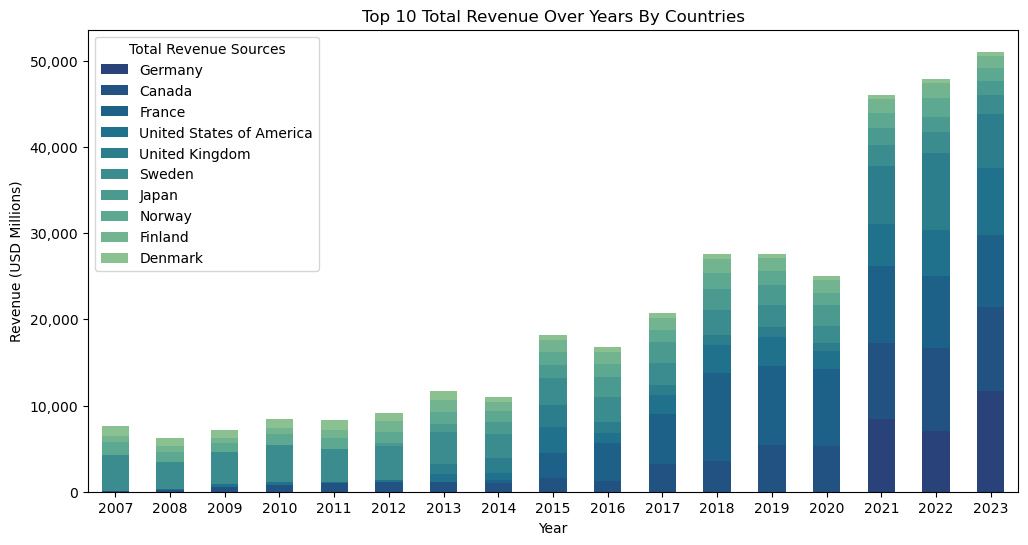

In [72]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('crest_r', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Total Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Total Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

## Crediting Market

In [73]:
sql_query = """
SELECT * FROM `carbon_pricing_latest_crediting_detail_`
"""

In [74]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_19915/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,Mechanism,Administration,Status,Year of Implementation,Scope,Administering Jurisdiction or organisation,Region,Credit name,Price (Range),Countries with project (ISO3 codes),...,Forestry / Land Use,Fugitive Emissions,Industrial Gases/Manufacturing,Renewable Energy,Transport,Waste,Cumulative_credits_issued,Cumulativ_ credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,Alberta Emission Offset System,Governmental,Implemented,2007,Subnational,Alberta,North America,"Emissions offset, Emission performance credits...",The TIER fund price is set at $65 per tonne of...,CAN,...,Yes,Yes,Yes,Yes,No,Yes,"88,589","62,869","1,255",406
1,American Carbon Registry,Independent,Implemented,1996,Global,,,Verified Emission Reductions (VERs),US$5.38/tCO2e (unweighted average) (2020),"BOL, BRA, CAN, FRA, MEX, NIC, SLV, THA, USA",...,Yes,No,Yes,Yes,Yes,Yes,"267,860","190,889","12,696",282
2,Australian Carbon Credit Unit Scheme (ACCU),Governmental,Implemented,2012,National,Australia,East Asia & Pacific,Australia Carbon Credit Unit (ACCU),A$30.50-32.00/tCO2e (US$20.05-21.70/tCO2e - av...,AUS,...,Yes,Yes,No,No,Yes,Yes,"140,400","104,200",200,"2,048"
3,Beijing Forestry Offset Mechanism,Governmental,Implemented,2014,Subnational,Beijing,East Asia & Pacific,Beijing Forestry Certified Emission Reductions...,CNY13.8-61/tCO2e (US$2.1-9.28/tCO2e) (2020),CHN,...,Yes,No,No,No,No,No,200,-,-,Not available
4,Beijing Parking Offset Crediting Mechanism,Governmental,Implemented,2017,Subnational,Beijing,East Asia & Pacific,Parking Certified Emission Reductions (PCERs),CNY56-130/tCO2e (US$7-19/tCO2e) (2023),CHN,...,No,No,No,No,Yes,No,200,15,Not available,Not available
5,British Columbia Offset Program,Governmental,Implemented,2016,Subnational,British Columbia,North America,British Columbia Offset Units and British Colu...,CAN$8-15/tCO2e (US$6-12/tCO2e) (2020),CAN,...,Yes,No,No,No,No,Yes,"17,151","6,336",-,46
6,California Compliance Offset Program,Governmental,Implemented,2013,Subnational,California,North America,Air Resources Board Offset Credits (ARBOCs) is...,US$20.99/tCO2e (weighted average price for 2023),USA,...,Yes,Yes,Yes,No,No,No,"256,912","164,614","6,451",521
7,Canada Federal GHG Offset System,Governmental,Implemented,2022,National,Canada,North America,Federal Offset Credit,n/a,CAN,...,,,,,,,-,-,-,1
8,Chile Green Tax Emissions Offsetting Scheme,Governmental,Implemented,2024,National,Chile,Latin America & Caribbean,No name or acronym associated yet.,,CHL,...,,,,,,,259,-,-,8
9,Clean Development Mechanism,International,Implemented,2006,Global,UNFCCC,,"Certified Emission Reduction (CER), temporary ...",,"ALB, ARE, ARG, ARM, AZE, BDI, BFA, BGD, BOL, B...",...,,,,,,,"2,431,808",Not available,"1,035","8,535"


In [75]:
df.rename(columns={'Price (Range)': 'Price', 'Cumulativ_ credits_retired': 'Cumulative_credits_retired', 'Countries with project (ISO3 codes)': 'ISO'}, inplace=True)

df

,Mechanism,Administration,Status,Year of Implementation,Scope,Administering Jurisdiction or organisation,Region,Credit name,Price,ISO,...,Forestry / Land Use,Fugitive Emissions,Industrial Gases/Manufacturing,Renewable Energy,Transport,Waste,Cumulative_credits_issued,Cumulative_credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,Alberta Emission Offset System,Governmental,Implemented,2007,Subnational,Alberta,North America,"Emissions offset, Emission performance credits...",The TIER fund price is set at $65 per tonne of...,CAN,...,Yes,Yes,Yes,Yes,No,Yes,"88,589","62,869","1,255",406
1,American Carbon Registry,Independent,Implemented,1996,Global,,,Verified Emission Reductions (VERs),US$5.38/tCO2e (unweighted average) (2020),"BOL, BRA, CAN, FRA, MEX, NIC, SLV, THA, USA",...,Yes,No,Yes,Yes,Yes,Yes,"267,860","190,889","12,696",282
2,Australian Carbon Credit Unit Scheme (ACCU),Governmental,Implemented,2012,National,Australia,East Asia & Pacific,Australia Carbon Credit Unit (ACCU),A$30.50-32.00/tCO2e (US$20.05-21.70/tCO2e - av...,AUS,...,Yes,Yes,No,No,Yes,Yes,"140,400","104,200",200,"2,048"
3,Beijing Forestry Offset Mechanism,Governmental,Implemented,2014,Subnational,Beijing,East Asia & Pacific,Beijing Forestry Certified Emission Reductions...,CNY13.8-61/tCO2e (US$2.1-9.28/tCO2e) (2020),CHN,...,Yes,No,No,No,No,No,200,-,-,Not available
4,Beijing Parking Offset Crediting Mechanism,Governmental,Implemented,2017,Subnational,Beijing,East Asia & Pacific,Parking Certified Emission Reductions (PCERs),CNY56-130/tCO2e (US$7-19/tCO2e) (2023),CHN,...,No,No,No,No,Yes,No,200,15,Not available,Not available
5,British Columbia Offset Program,Governmental,Implemented,2016,Subnational,British Columbia,North America,British Columbia Offset Units and British Colu...,CAN$8-15/tCO2e (US$6-12/tCO2e) (2020),CAN,...,Yes,No,No,No,No,Yes,"17,151","6,336",-,46
6,California Compliance Offset Program,Governmental,Implemented,2013,Subnational,California,North America,Air Resources Board Offset Credits (ARBOCs) is...,US$20.99/tCO2e (weighted average price for 2023),USA,...,Yes,Yes,Yes,No,No,No,"256,912","164,614","6,451",521
7,Canada Federal GHG Offset System,Governmental,Implemented,2022,National,Canada,North America,Federal Offset Credit,n/a,CAN,...,,,,,,,-,-,-,1
8,Chile Green Tax Emissions Offsetting Scheme,Governmental,Implemented,2024,National,Chile,Latin America & Caribbean,No name or acronym associated yet.,,CHL,...,,,,,,,259,-,-,8
9,Clean Development Mechanism,International,Implemented,2006,Global,UNFCCC,,"Certified Emission Reduction (CER), temporary ...",,"ALB, ARE, ARG, ARM, AZE, BDI, BFA, BGD, BOL, B...",...,,,,,,,"2,431,808",Not available,"1,035","8,535"


In [76]:
df['Price'].value_counts()

Price
                                                                                                                                                                                         20
Not available                                                                                                                                                                             2
n/a                                                                                                                                                                                       2
CAD65/tCO2e                                                                                                                                                                               1
US$1.62/tCO2e (2020)                                                                                                                                                                      1
CHF56-151/tCO2e (US$59-160/tCO2e) (2020)              

In [77]:
import re

# Extract price information from the text
def extract_price(text):
    # Regular expression pattern to find price information in the format US$X.XX
    pattern = r'US\$(\d+(\.\d+)?)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Return the price value
    else:
        return None  # Return None if price information is not found

# Apply the function to extract price information from the 'Price' column
df['Price_USD'] = df['Price'].apply(extract_price)

df['Price_USD']

0      None
1      5.38
2     20.05
3       2.1
4         7
5         6
6     20.99
7      None
8      None
9      None
10     2.34
11     None
12     None
13     None
14     None
15     None
16     5.27
17     None
18     None
19     None
20     None
21       67
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29      2.0
30     None
31    20.88
32      5.6
33        5
34     None
35        1
36     None
37     None
38    11.39
39     None
40       59
41     None
42     1.62
43     None
44     None
45     None
Name: Price_USD, dtype: object

In [78]:
import numpy as np
# 先將空值替換成NaN
df['Price'] = df['Price'].replace('', np.nan)

df_price = pd.DataFrame({'Mechanism': df['Mechanism'], 'Price': df['Price_USD']})
df_price

,Mechanism,Price
0,Alberta Emission Offset System,None
1,American Carbon Registry,5.38
2,Australian Carbon Credit Unit Scheme (ACCU),20.05
3,Beijing Forestry Offset Mechanism,2.1
4,Beijing Parking Offset Crediting Mechanism,7
5,British Columbia Offset Program,6
6,California Compliance Offset Program,20.99
7,Canada Federal GHG Offset System,None
8,Chile Green Tax Emissions Offsetting Scheme,None
9,Clean Development Mechanism,None


In [79]:
df_price = df_price.dropna(subset=['Price'])
df_price

,Mechanism,Price
1,American Carbon Registry,5.38
2,Australian Carbon Credit Unit Scheme (ACCU),20.05
3,Beijing Forestry Offset Mechanism,2.1
4,Beijing Parking Offset Crediting Mechanism,7
5,British Columbia Offset Program,6
6,California Compliance Offset Program,20.99
10,Climate Action Reserve,2.34
16,Gold Standard,5.27
21,J-Credit Scheme,67
29,Plan Vivo,2.0


### 從價格來看，各機制的平均數大概是在每公噸CO2排放量為14.27美元左右

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_19915/1037738310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')


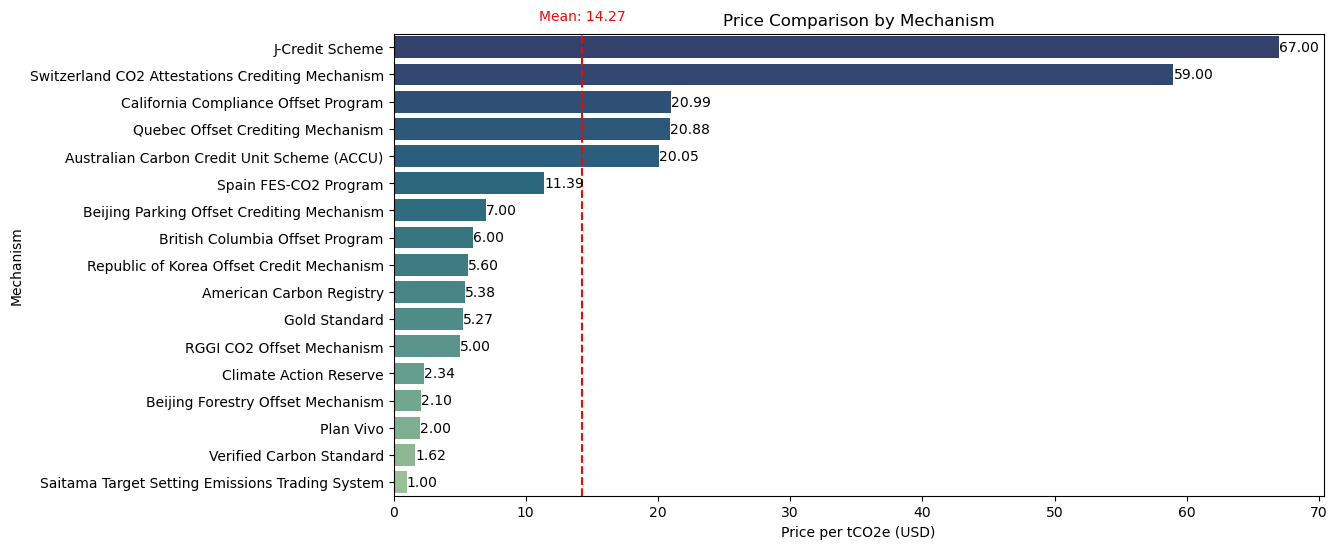

In [80]:
df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')
df_price = df_price.sort_values(by='Price', ascending=False)

plt.figure(figsize=(12, 6))

# Use barplot instead of histplot
sns.barplot(data=df_price, x='Price', y='Mechanism', palette='crest_r')

# Add text labels for each bar
for index, value in enumerate(df_price['Price']):
    plt.text(value, index, f'{value:.2f}', va='center')

# Calculate mean and add a vertical line
mean_price = df_price['Price'].mean()
plt.axvline(mean_price, color='red', linestyle='--', label=f'Mean Price: {mean_price:.2f} USD')

# Display the mean value on the plot
plt.text(mean_price, plt.gca().get_ylim()[1] - 0.5, f'Mean: {mean_price:.2f}', color='red', ha='center')

plt.title('Price Comparison by Mechanism')
plt.xlabel('Price per tCO2e (USD)')
plt.ylabel('Mechanism')

plt.show()

### 累計發行的碳信用額度、累計銷售的碳信用額度、累計取消的碳信用額度、累計註冊的項目

In [81]:
df.columns

Index(['Mechanism', 'Administration', 'Status', 'Year of Implementation',
       'Scope', 'Administering Jurisdiction or organisation', 'Region',
       'Credit name', 'Price', 'ISO', 'Agriculture', 'CCS / CCU',
       'Energy Efficiency / Fuel Switching', 'Forestry / Land Use',
       'Fugitive Emissions', 'Industrial Gases/Manufacturing',
       'Renewable Energy', 'Transport', 'Waste', 'Cumulative_credits_issued',
       'Cumulative_credits_retired', 'Cumulative_credits_cancelled',
       'Cumulative_projects_registered', 'Price_USD'],
      dtype='object')

In [82]:
def clean_and_convert(column):
    return pd.to_numeric(column.str.replace(',', '').str.strip(), errors='coerce').fillna(0).astype(int)

# Apply the function to specific columns
columns_to_convert = ['Cumulative_credits_issued', 'Cumulative_credits_retired', 'Cumulative_credits_cancelled', 'Cumulative_projects_registered']
df[columns_to_convert] = df[columns_to_convert].apply(clean_and_convert)
df[columns_to_convert]

,Cumulative_credits_issued,Cumulative_credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,88589,62869,1255,406
1,267860,190889,12696,282
2,140400,104200,200,2048
3,200,0,0,0
4,200,15,0,0
5,17151,6336,0,46
6,256912,164614,6451,521
7,0,0,0,1
8,259,0,0,8
9,2431808,0,1035,8535


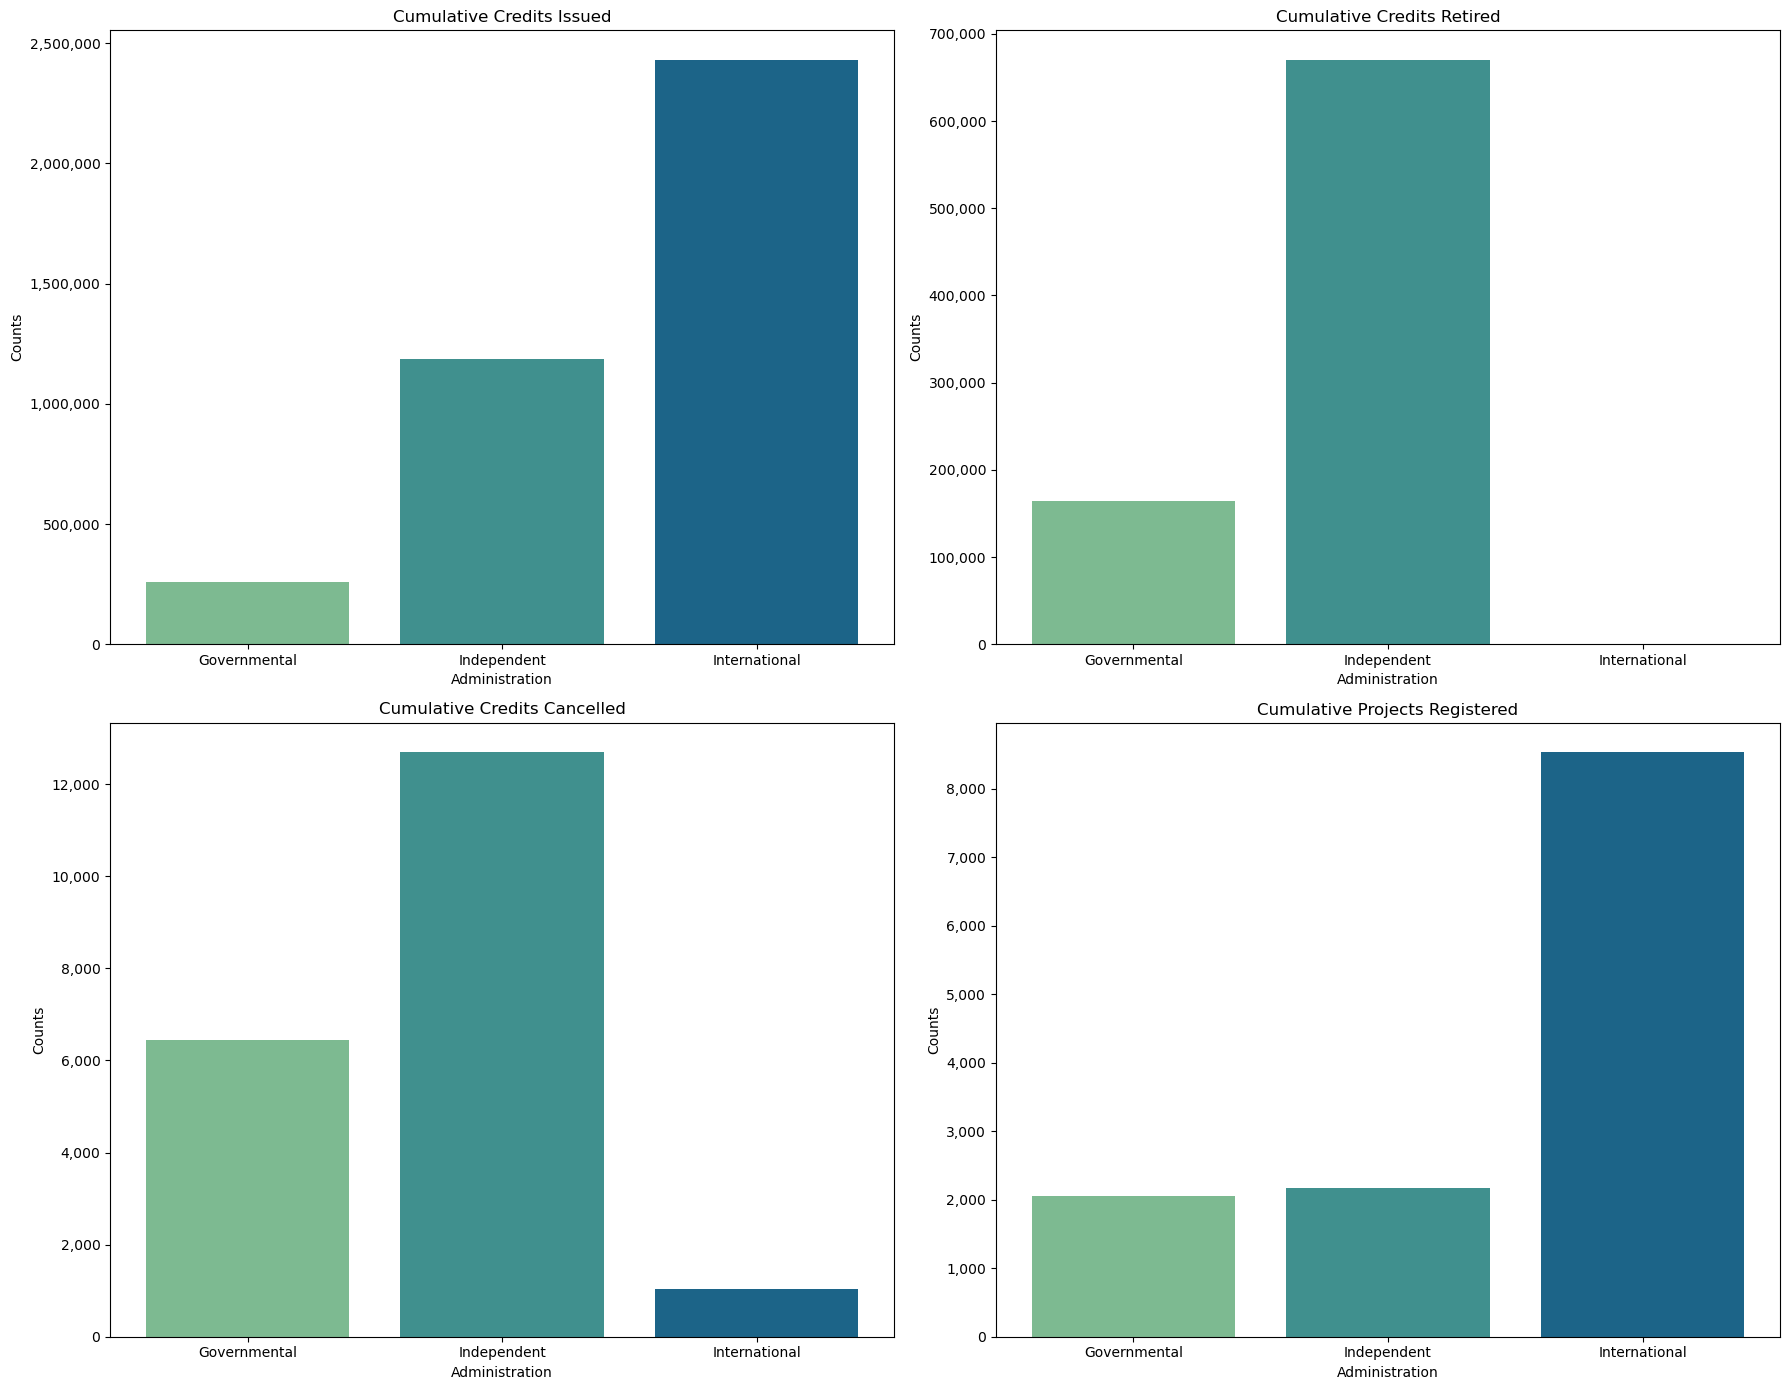

In [83]:
colors = {
    'Governmental': sns.color_palette('crest')[0],
    'Independent': sns.color_palette('crest')[2],
    'International': sns.color_palette('crest')[4]
}

df['Color'] = df['Administration'].map(colors)

# Create custom formatter for y-axis labels
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot Cumulative Credits Issued
axes[0, 0].bar(df['Administration'], df['Cumulative_credits_issued'], color=df['Color'])
axes[0, 0].set_title('Cumulative Credits Issued')
axes[0, 0].set_xlabel('Administration')
axes[0, 0].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[0, 0].tick_params(axis='x')
axes[0, 0].yaxis.set_major_formatter(formatter)

# Plot Cumulative Credits Retired
axes[0, 1].bar(df['Administration'], df['Cumulative_credits_retired'], color=df['Color'])
axes[0, 1].set_title('Cumulative Credits Retired')
axes[0, 1].set_xlabel('Administration')
axes[0, 1].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[0, 1].tick_params(axis='x')
axes[0, 1].yaxis.set_major_formatter(formatter)

# Plot Cumulative Credits Cancelled
axes[1, 0].bar(df['Administration'], df['Cumulative_credits_cancelled'], color=df['Color'])
axes[1, 0].set_title('Cumulative Credits Cancelled')
axes[1, 0].set_xlabel('Administration')
axes[1, 0].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[1, 0].tick_params(axis='x')
axes[1, 0].yaxis.set_major_formatter(formatter)

# Plot Cumulative Projects Registered
axes[1, 1].bar(df['Administration'], df['Cumulative_projects_registered'], color=df['Color'])
axes[1, 1].set_title('Cumulative Projects Registered')
axes[1, 1].set_xlabel('Administration')
axes[1, 1].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[1, 1].tick_params(axis='x')
axes[1, 1].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

---

## 分布狀況

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import matplotlib.ticker as ticker
import urllib.request
import pycountry
import matplotlib.colors as mcolors
import branca.colormap as cm

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `crediting_detail`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_10122/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,Mechanism,Administration,Status,Year,Scope,Administering Jurisdiction or organisation,Region,Credit name,ISO,Agriculture,...,Forestry / Land Use,Fugitive Emissions,Industrial Gases/Manufacturing,Renewable Energy,Transport,Waste,Cumulative_credits_issued,Cumulative_credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,American Carbon Registry,Independent,Implemented,1996,Global,,,Verified Emission Reductions (VERs),"BOL, BRA, CAN, FRA, MEX, NIC, SLV, THA, USA",Yes,...,Yes,No,Yes,Yes,Yes,Yes,"267,860","190,889","12,696",282
1,Australian Carbon Credit Unit Scheme (ACCU),Governmental,Implemented,2012,National,Australia,East Asia & Pacific,Australia Carbon Credit Unit (ACCU),AUS,Yes,...,Yes,Yes,No,No,Yes,Yes,"140,400","104,200",200,"2,048"
2,Beijing Forestry Offset Mechanism,Governmental,Implemented,2014,Subnational,Beijing,East Asia & Pacific,Beijing Forestry Certified Emission Reductions...,CHN,No,...,Yes,No,No,No,No,No,200,-,-,Not available
3,Beijing Parking Offset Crediting Mechanism,Governmental,Implemented,2017,Subnational,Beijing,East Asia & Pacific,Parking Certified Emission Reductions (PCERs),CHN,No,...,No,No,No,No,Yes,No,200,15,Not available,Not available
4,British Columbia Offset Program,Governmental,Implemented,2016,Subnational,British Columbia,North America,British Columbia Offset Units and British Colu...,CAN,No,...,Yes,No,No,No,No,Yes,"17,151","6,336",-,46
5,California Compliance Offset Program,Governmental,Implemented,2013,Subnational,California,North America,Air Resources Board Offset Credits (ARBOCs) is...,USA,Yes,...,Yes,Yes,Yes,No,No,No,"256,912","164,614","6,451",521
6,Canada Federal GHG Offset System,Governmental,Implemented,2022,National,Canada,North America,Federal Offset Credit,CAN,,...,,,,,,,-,-,-,1
7,Chile Green Tax Emissions Offsetting Scheme,Governmental,Implemented,2024,National,Chile,Latin America & Caribbean,No name or acronym associated yet.,CHL,,...,,,,,,,259,-,-,8
8,China GHG Voluntary Emission Reduction Program,Governmental,Implemented,2014,National,China,East Asia & Pacific,Chinese Certified Emission Reductions (CCERs),CHN,No,...,Yes,No,No,Yes,No,Yes,"77,000","69,000","8,000","1,047"
9,Chongqing carbon offset mechanism,Governmental,Implemented,2021,Subnational,Chongqing,East Asia & Pacific,Chongqing Certified Emission Reduction (CQCER),CHN,No,...,Yes,No,No,Yes,No,Yes,"1,915",-,-,Not available


In [4]:
df.rename(columns={'Price (Range)': 'Price', 'Cumulativ_ credits_retired': 'Cumulative_credits_retired', 'Countries with project (ISO3 codes)': 'ISO'}, inplace=True)

df

,Mechanism,Administration,Status,Year,Scope,Administering Jurisdiction or organisation,Region,Credit name,ISO,Agriculture,...,Forestry / Land Use,Fugitive Emissions,Industrial Gases/Manufacturing,Renewable Energy,Transport,Waste,Cumulative_credits_issued,Cumulative_credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,American Carbon Registry,Independent,Implemented,1996,Global,,,Verified Emission Reductions (VERs),"BOL, BRA, CAN, FRA, MEX, NIC, SLV, THA, USA",Yes,...,Yes,No,Yes,Yes,Yes,Yes,"267,860","190,889","12,696",282
1,Australian Carbon Credit Unit Scheme (ACCU),Governmental,Implemented,2012,National,Australia,East Asia & Pacific,Australia Carbon Credit Unit (ACCU),AUS,Yes,...,Yes,Yes,No,No,Yes,Yes,"140,400","104,200",200,"2,048"
2,Beijing Forestry Offset Mechanism,Governmental,Implemented,2014,Subnational,Beijing,East Asia & Pacific,Beijing Forestry Certified Emission Reductions...,CHN,No,...,Yes,No,No,No,No,No,200,-,-,Not available
3,Beijing Parking Offset Crediting Mechanism,Governmental,Implemented,2017,Subnational,Beijing,East Asia & Pacific,Parking Certified Emission Reductions (PCERs),CHN,No,...,No,No,No,No,Yes,No,200,15,Not available,Not available
4,British Columbia Offset Program,Governmental,Implemented,2016,Subnational,British Columbia,North America,British Columbia Offset Units and British Colu...,CAN,No,...,Yes,No,No,No,No,Yes,"17,151","6,336",-,46
5,California Compliance Offset Program,Governmental,Implemented,2013,Subnational,California,North America,Air Resources Board Offset Credits (ARBOCs) is...,USA,Yes,...,Yes,Yes,Yes,No,No,No,"256,912","164,614","6,451",521
6,Canada Federal GHG Offset System,Governmental,Implemented,2022,National,Canada,North America,Federal Offset Credit,CAN,,...,,,,,,,-,-,-,1
7,Chile Green Tax Emissions Offsetting Scheme,Governmental,Implemented,2024,National,Chile,Latin America & Caribbean,No name or acronym associated yet.,CHL,,...,,,,,,,259,-,-,8
8,China GHG Voluntary Emission Reduction Program,Governmental,Implemented,2014,National,China,East Asia & Pacific,Chinese Certified Emission Reductions (CCERs),CHN,No,...,Yes,No,No,Yes,No,Yes,"77,000","69,000","8,000","1,047"
9,Chongqing carbon offset mechanism,Governmental,Implemented,2021,Subnational,Chongqing,East Asia & Pacific,Chongqing Certified Emission Reduction (CQCER),CHN,No,...,Yes,No,No,Yes,No,Yes,"1,915",-,-,Not available


In [5]:
# Splitting ISO codes and creating a new DataFrame with individual ISO codes
iso_split = df['ISO'].str.split(', ')
scope_iso = pd.DataFrame({
    'Mechanism': df['Mechanism'].repeat(iso_split.str.len()),
    'Scope': df['Scope'].repeat(iso_split.str.len()),
    'ISO': [iso for sublist in iso_split for iso in sublist]
})

# Reset index
scope_iso.reset_index(drop=True, inplace=True)
scope_iso

,Mechanism,Scope,ISO
0,American Carbon Registry,Global,BOL
1,American Carbon Registry,Global,BRA
2,American Carbon Registry,Global,CAN
3,American Carbon Registry,Global,FRA
4,American Carbon Registry,Global,MEX
...,...,...,...
339,Verified Carbon Standard,Global,ZMB
340,Verified Carbon Standard,Global,ZWE
341,Vietnam Crediting Mechanism,National,
342,Voluntary Carbon Credit System,Subnational,


In [6]:
# Mapping country names to ISO codes
country_iso_mapping = {}
for country in pycountry.countries:
    if hasattr(country, 'alpha_3'):
        country_iso_mapping[country.name] = country.alpha_3

country_iso_mapping

{'Aruba': 'ABW',
 'Afghanistan': 'AFG',
 'Angola': 'AGO',
 'Anguilla': 'AIA',
 'Åland Islands': 'ALA',
 'Albania': 'ALB',
 'Andorra': 'AND',
 'United Arab Emirates': 'ARE',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'American Samoa': 'ASM',
 'Antarctica': 'ATA',
 'French Southern Territories': 'ATF',
 'Antigua and Barbuda': 'ATG',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Burundi': 'BDI',
 'Belgium': 'BEL',
 'Benin': 'BEN',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Burkina Faso': 'BFA',
 'Bangladesh': 'BGD',
 'Bulgaria': 'BGR',
 'Bahrain': 'BHR',
 'Bahamas': 'BHS',
 'Bosnia and Herzegovina': 'BIH',
 'Saint Barthélemy': 'BLM',
 'Belarus': 'BLR',
 'Belize': 'BLZ',
 'Bermuda': 'BMU',
 'Bolivia, Plurinational State of': 'BOL',
 'Brazil': 'BRA',
 'Barbados': 'BRB',
 'Brunei Darussalam': 'BRN',
 'Bhutan': 'BTN',
 'Bouvet Island': 'BVT',
 'Botswana': 'BWA',
 'Central African Republic': 'CAF',
 'Canada': 'CAN',
 'Cocos (Keeling) Islands': 'CCK',
 'Switzerland': 'CHE',
 

In [7]:
# Splitting ISO codes and creating a new DataFrame with individual ISO codes
iso_split = df['ISO'].str.split(', ')
scope_iso = pd.DataFrame({
    'Mechanism': df['Mechanism'].repeat(iso_split.str.len()),
    'Scope': df['Scope'].repeat(iso_split.str.len()),
    'ISO': [iso for sublist in iso_split for iso in sublist]
})

# Reset indexx
scope_iso.reset_index(drop=True, inplace=True)
scope_iso

,Mechanism,Scope,ISO
0,American Carbon Registry,Global,BOL
1,American Carbon Registry,Global,BRA
2,American Carbon Registry,Global,CAN
3,American Carbon Registry,Global,FRA
4,American Carbon Registry,Global,MEX
...,...,...,...
339,Verified Carbon Standard,Global,ZMB
340,Verified Carbon Standard,Global,ZWE
341,Vietnam Crediting Mechanism,National,
342,Voluntary Carbon Credit System,Subnational,


In [8]:
blank_iso_rows = scope_iso[scope_iso['ISO'] == '']
blank_iso_rows

,Mechanism,Scope,ISO
102,Climate Credit System,Subnational,
104,Ecuador Crediting Mechanism,National,
105,Egypt Crediting Mechanism,National,
106,EU Carbon Removal Certification Framework,Regional,
184,India Crediting Mechanism,National,
185,Indo-Pacific Carbon Offsets Scheme,Regional,
186,Indonesia Crediting Mechanism,National,
217,Mexico Crediting Mechanism,National,
218,Murcia Crediting Mechanism,Subnational,
341,Vietnam Crediting Mechanism,National,


In [9]:
iso_values = [None, 'ECU', 'EGY', None, 'IND', None, 'IDN', 'MEX', 'ESP', 'VNM', None]
scope_iso.loc[blank_iso_rows.index, 'ISO'] = iso_values
scope_iso

,Mechanism,Scope,ISO
0,American Carbon Registry,Global,BOL
1,American Carbon Registry,Global,BRA
2,American Carbon Registry,Global,CAN
3,American Carbon Registry,Global,FRA
4,American Carbon Registry,Global,MEX
...,...,...,...
339,Verified Carbon Standard,Global,ZMB
340,Verified Carbon Standard,Global,ZWE
341,Vietnam Crediting Mechanism,National,VNM
342,Voluntary Carbon Credit System,Subnational,None


In [10]:
# 修改台灣名稱
country_iso_mapping['Taiwan'] = country_iso_mapping.pop('Taiwan, Province of China')

In [11]:
# 計算各國參與機制數
country_counts = scope_iso['ISO'].value_counts().to_dict()

world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
with urllib.request.urlopen(world_geojson_url) as response:
    world_geojson = json.load(response)


cmap = sns.color_palette('crest', as_cmap=True)

m = folium.Map(location=[0, 0], zoom_start=2, min_zoom=2, max_zoom=10)

def style_function(feature):
    country_iso = feature['id']
    count = country_counts.get(country_iso, 0)
    
    if count > 0:
        color = cmap(count / max(country_counts.values()))
        color = mcolors.rgb2hex(color)
    else:
        color = '#e8dfd8'
    
    return {
        'fillColor': color,
        'fillOpacity': 0.7,
        'weight': 1.0,
        'color': None
    }

geojson_layer = folium.GeoJson(
    world_geojson, 
    style_function=style_function
).add_to(m)

# tooltip
for feature in world_geojson['features']:
    country_iso = feature['id']
    if country_iso in country_iso_mapping.values():
        country_name = [name for name, iso in country_iso_mapping.items() if iso == country_iso][0]
        count = country_counts.get(country_iso, 0)
        tooltip = folium.Tooltip(f"""
            Country: {country_name}<br>
            Mechanism Count: {count}
        """)
        folium.GeoJson(
            feature, 
            tooltip=tooltip, 
            style_function=style_function
        ).add_to(m)

# colormap
colormap = cm.LinearColormap(
    cmap.colors,
    vmin=1, # min=1, not 0(Not Applicable)
    vmax=max(country_counts.values()),
    caption='Mechanism Count'
)

colormap.add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 30px; width: 180px; height: 80px; 
                 border:2px solid grey; z-index:9999; font-size:11px;
                 background-color:white; opacity: 0.8; padding: 10px;">
     </div>
     '''
m.save('credit.html')
m

In [12]:
scope_iso

,Mechanism,Scope,ISO
0,American Carbon Registry,Global,BOL
1,American Carbon Registry,Global,BRA
2,American Carbon Registry,Global,CAN
3,American Carbon Registry,Global,FRA
4,American Carbon Registry,Global,MEX
...,...,...,...
339,Verified Carbon Standard,Global,ZMB
340,Verified Carbon Standard,Global,ZWE
341,Vietnam Crediting Mechanism,National,VNM
342,Voluntary Carbon Credit System,Subnational,None


In [13]:
scope_iso['ISO'].value_counts()

ISO
CHN    9
MEX    7
USA    7
CAN    6
THA    6
      ..
NCL    1
SDN    1
SOM    1
TCD    1
TKM    1
Name: count, Length: 140, dtype: int64

In [14]:
national_counts = scope_iso.query("Scope == 'National'").groupby('ISO').size()
subnational_counts = scope_iso.query("Scope == 'Subnational'").groupby('ISO').size()
global_counts = scope_iso.query("Scope == 'Global'").groupby('ISO').size()
regional_counts = scope_iso.query("Scope == 'Regional'").groupby('ISO').size()

print(national_counts)
print(subnational_counts)
print(global_counts)
print(regional_counts )

ISO
AUS    1
CAN    1
CHE    1
CHL    1
CHN    1
COL    1
ECU    1
EGY    1
ESP    1
GBR    2
IDN    1
IND    1
JPN    1
KAZ    1
KOR    1
LKA    1
MEX    1
PRT    1
SAU    1
THA    1
TWN    1
VNM    1
ZAF    1
dtype: int64
ISO
CAN    3
CHN    5
ESP    1
JPN    2
RUS    1
USA    3
dtype: int64
ISO
ABW    1
AGO    1
ALB    1
ARE    2
ARG    3
      ..
VNM    3
VUT    1
ZAF    3
ZMB    3
ZWE    2
Length: 135, dtype: int64
ISO
BGD    1
IDN    1
KEN    1
KHM    1
LAO    1
MDV    1
MNG    1
PLW    1
SAU    1
THA    1
VNM    1
dtype: int64


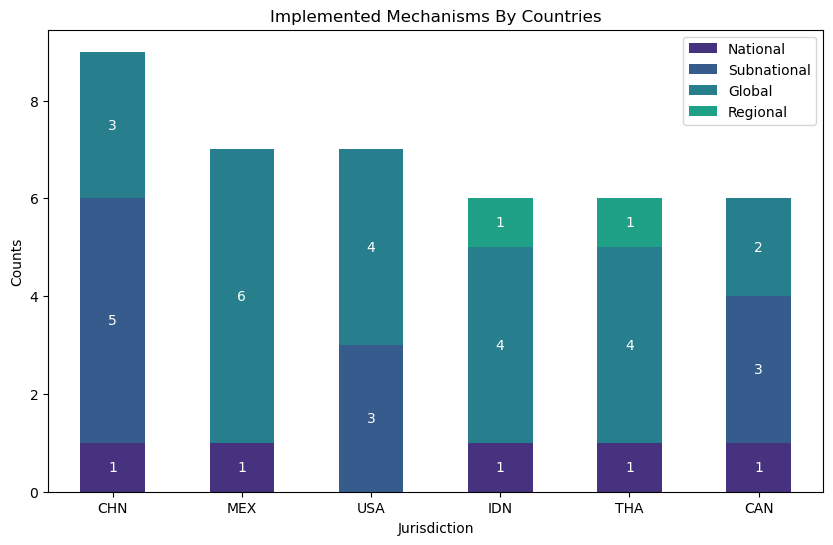

In [15]:
merged_counts = pd.concat([national_counts, subnational_counts, global_counts, regional_counts], axis=1)
merged_counts.columns = ['National', 'Subnational', 'Global', 'Regional']

# 計算每個jurisdiction的總數量並排序
merged_counts['Total'] = merged_counts.sum(axis=1)  # 計算總數量
merged_counts = merged_counts.sort_values(by='Total', ascending=False) 
merged_counts = merged_counts.head(6)

colors = sns.color_palette('viridis', len(merged_counts))

# 提取索引中的國家名稱作為 x 軸標籤
countries = merged_counts.index.get_level_values(0)

ax = merged_counts.drop(columns='Total').plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

for p in ax.patches:
    width = p.get_width()  # width
    height = p.get_height()  # height
    x, y = p.get_xy()  # 起始點座標
    if height > 0: 
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')
        
    
# 設置標籤和標題
plt.xlabel('Jurisdiction')
plt.ylabel('Counts')
plt.title('Implemented Mechanisms By Countries')
plt.xticks(rotation=0)

# 顯示圖形
plt.show()

---

### 實行中類型、數量

In [16]:
df

,Mechanism,Administration,Status,Year,Scope,Administering Jurisdiction or organisation,Region,Credit name,ISO,Agriculture,...,Forestry / Land Use,Fugitive Emissions,Industrial Gases/Manufacturing,Renewable Energy,Transport,Waste,Cumulative_credits_issued,Cumulative_credits_retired,Cumulative_credits_cancelled,Cumulative_projects_registered
0,American Carbon Registry,Independent,Implemented,1996,Global,,,Verified Emission Reductions (VERs),"BOL, BRA, CAN, FRA, MEX, NIC, SLV, THA, USA",Yes,...,Yes,No,Yes,Yes,Yes,Yes,"267,860","190,889","12,696",282
1,Australian Carbon Credit Unit Scheme (ACCU),Governmental,Implemented,2012,National,Australia,East Asia & Pacific,Australia Carbon Credit Unit (ACCU),AUS,Yes,...,Yes,Yes,No,No,Yes,Yes,"140,400","104,200",200,"2,048"
2,Beijing Forestry Offset Mechanism,Governmental,Implemented,2014,Subnational,Beijing,East Asia & Pacific,Beijing Forestry Certified Emission Reductions...,CHN,No,...,Yes,No,No,No,No,No,200,-,-,Not available
3,Beijing Parking Offset Crediting Mechanism,Governmental,Implemented,2017,Subnational,Beijing,East Asia & Pacific,Parking Certified Emission Reductions (PCERs),CHN,No,...,No,No,No,No,Yes,No,200,15,Not available,Not available
4,British Columbia Offset Program,Governmental,Implemented,2016,Subnational,British Columbia,North America,British Columbia Offset Units and British Colu...,CAN,No,...,Yes,No,No,No,No,Yes,"17,151","6,336",-,46
5,California Compliance Offset Program,Governmental,Implemented,2013,Subnational,California,North America,Air Resources Board Offset Credits (ARBOCs) is...,USA,Yes,...,Yes,Yes,Yes,No,No,No,"256,912","164,614","6,451",521
6,Canada Federal GHG Offset System,Governmental,Implemented,2022,National,Canada,North America,Federal Offset Credit,CAN,,...,,,,,,,-,-,-,1
7,Chile Green Tax Emissions Offsetting Scheme,Governmental,Implemented,2024,National,Chile,Latin America & Caribbean,No name or acronym associated yet.,CHL,,...,,,,,,,259,-,-,8
8,China GHG Voluntary Emission Reduction Program,Governmental,Implemented,2014,National,China,East Asia & Pacific,Chinese Certified Emission Reductions (CCERs),CHN,No,...,Yes,No,No,Yes,No,Yes,"77,000","69,000","8,000","1,047"
9,Chongqing carbon offset mechanism,Governmental,Implemented,2021,Subnational,Chongqing,East Asia & Pacific,Chongqing Certified Emission Reduction (CQCER),CHN,No,...,Yes,No,No,Yes,No,Yes,"1,915",-,-,Not available


In [17]:
df['Scope'].value_counts()

Scope
National       24
Subnational    17
Global          7
Regional        3
Name: count, dtype: int64

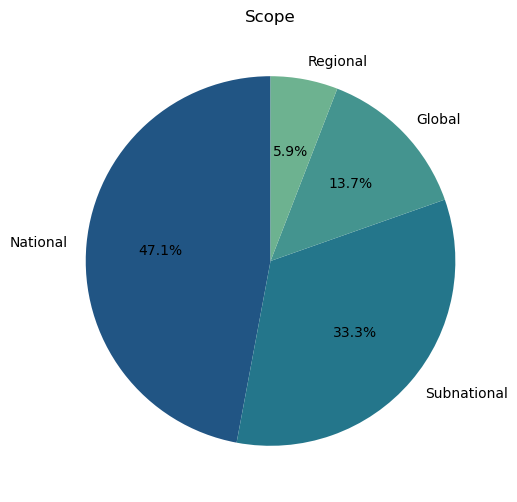

In [18]:
# Define your scope data
scope_data = pd.DataFrame({'Scope': ['National', 'Subnational', 'Global', 'Regional'], 'count': [24, 17, 7, 3]})

# Set a custom color palette
colors = sns.color_palette('crest_r', len(scope_data)) #'YlGn_r'

plt.figure(figsize=(8, 6))
plt.pie(scope_data['count'], labels=scope_data['Scope'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Scope')

plt.show()


In [19]:
df['Status'].value_counts()

Status
Implemented          40
Under development    11
Name: count, dtype: int64

### 目前全球已經開始實行的合規機制數量為40個（78.4%），還沒正式上路、仍在計畫中的為11個（21.6%）

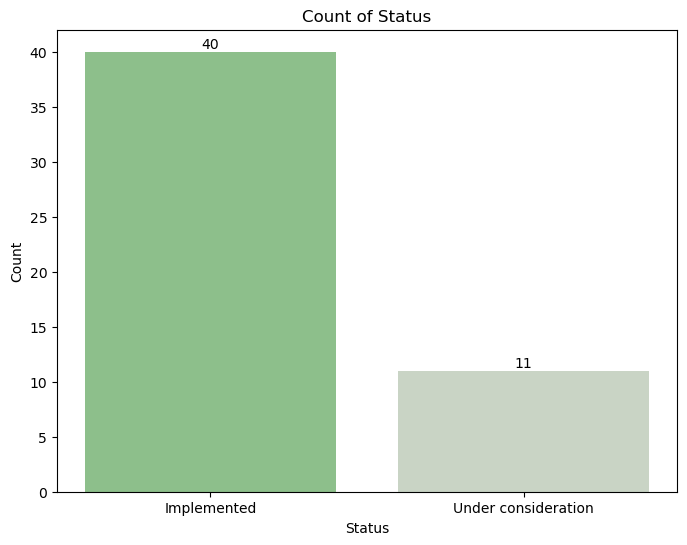

In [20]:
status_data = pd.DataFrame({'df': ['Implemented', 'Under consideration'], 'count': [40, 11]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
bars = plt.bar(status_data['df'], status_data['count'], color=colors)

# 標數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of Status')

plt.show()

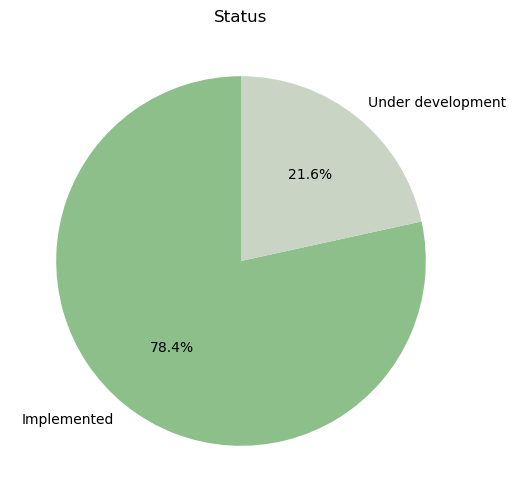

In [21]:
status_data = pd.DataFrame({'Status': ['Implemented', 'Under development'], 'count': [40, 11]})

colors=['#8dbf8b', '#C9D4C5'] #colors = sns.color_palette('YlGn_r', len(status_data))

plt.figure(figsize=(8, 6))
plt.pie(status_data['count'], labels=status_data['Status'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Status')

plt.show()

---

## Crediting Issuance

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import urllib

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `carbon_pricing_latest_crediting_issuance`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_28902/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,Mechanism,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Alberta Emission Offset System,-,-,-,-,-,-,-,-,-,...,-,"4,011,000","4,463,000","5,057,000","4,866,000","3,618,000","8,400,000","393,000","6,400,000","7,799,074"
1,American Carbon Registry,"125,000",-,500,"2,880,358","11,027,146","5,847,510","7,938,812","6,245,281","171,069",...,"4,287,042","8,732,794","27,095,713","47,983,817","12,048,989","14,229,468","28,693,311","17,563,259","29,322,192","37,355,459"
2,Australian Carbon Credit Unit Scheme (ACCU),-,-,-,-,-,-,-,-,-,...,"7,600,000","7,900,000","13,100,000","12,200,000","12,400,000","14,800,000","16,100,000","17,100,000","17,700,000","17,200,000"
3,Beijing Forestry Offset Mechanism,-,-,-,-,-,-,-,-,-,...,-,"45,000","45,000",-,-,-,-,-,-,-
4,Beijing Parking Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,"2,128",-,-
5,British Columbia Offset Program,-,-,-,-,-,-,-,-,-,...,-,-,"768,150","3,119,145","205,507","2,107,083","1,356,296","1,210,721","4,835,135","1,930,665"
6,California Compliance Offset Program,-,-,-,-,-,-,-,-,-,...,"10,983,823","19,561,213","19,776,011","32,732,903","54,732,348","26,541,225","45,543,188","17,409,784","11,565,096","13,797,604"
7,Chile Green Tax Emissions Offsetting Scheme,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,"258,547"
8,China GHG Voluntary Emission Reduction Program,-,-,-,-,-,-,-,-,-,...,"21,000,000","28,000,000","4,000,000",-,-,-,-,-,-,-
9,Chongqing carbon offset mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,"1,200,000","350,000","365,198"


In [4]:
country = ['Canada', 'United States', 'Australia', 'China', 'China', 'Canada', 'United States',
           'Chile', 'China', 'China',None, None, 'Colombia', 'China', None, 'China', 'Japan', None, None, 
           'Kazakhstan', None, 'Canada',  'South Korea', 'United States', 'Japan', 'Japan', 'Russia', 'South Africa', 
           'Spain', 'Sri Lanka', 'Switzerland', 'Taiwan', 'Thailand', 'Japan', 'United Kingdom', None, 'United States']
country_series = pd.Series(country)

In [5]:
df['country'] = country_series
df

,Mechanism,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,country
0,Alberta Emission Offset System,-,-,-,-,-,-,-,-,-,...,"4,011,000","4,463,000","5,057,000","4,866,000","3,618,000","8,400,000","393,000","6,400,000","7,799,074",Canada
1,American Carbon Registry,"125,000",-,500,"2,880,358","11,027,146","5,847,510","7,938,812","6,245,281","171,069",...,"8,732,794","27,095,713","47,983,817","12,048,989","14,229,468","28,693,311","17,563,259","29,322,192","37,355,459",United States
2,Australian Carbon Credit Unit Scheme (ACCU),-,-,-,-,-,-,-,-,-,...,"7,900,000","13,100,000","12,200,000","12,400,000","14,800,000","16,100,000","17,100,000","17,700,000","17,200,000",Australia
3,Beijing Forestry Offset Mechanism,-,-,-,-,-,-,-,-,-,...,"45,000","45,000",-,-,-,-,-,-,-,China
4,Beijing Parking Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,"2,128",-,-,China
5,British Columbia Offset Program,-,-,-,-,-,-,-,-,-,...,-,"768,150","3,119,145","205,507","2,107,083","1,356,296","1,210,721","4,835,135","1,930,665",Canada
6,California Compliance Offset Program,-,-,-,-,-,-,-,-,-,...,"19,561,213","19,776,011","32,732,903","54,732,348","26,541,225","45,543,188","17,409,784","11,565,096","13,797,604",United States
7,Chile Green Tax Emissions Offsetting Scheme,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,"258,547",Chile
8,China GHG Voluntary Emission Reduction Program,-,-,-,-,-,-,-,-,-,...,"28,000,000","4,000,000",-,-,-,-,-,-,-,China
9,Chongqing carbon offset mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,"1,200,000","350,000","365,198",China


In [6]:
# transpose year
ts = df.melt(id_vars=['Mechanism', 'country'], var_name='Year')
ts

,Mechanism,country,Year,value
0,Alberta Emission Offset System,Canada,2002,-
1,American Carbon Registry,United States,2002,"125,000"
2,Australian Carbon Credit Unit Scheme (ACCU),Australia,2002,-
3,Beijing Forestry Offset Mechanism,China,2002,-
4,Beijing Parking Offset Crediting Mechanism,China,2002,-
...,...,...,...,...
809,Thailand Voluntary Emission Reduction Program,Thailand,2023,"3,058,737"
810,Tokyo Cap-and-Trade Program,Japan,2023,"40,000"
811,UK Woodland Carbon Code,United Kingdom,2023,-
812,Verified Carbon Standard,None,2023,"148,384,227"


In [7]:
ts['Year'] = pd.to_datetime(ts['Year'], format='%Y')
ts

,Mechanism,country,Year,value
0,Alberta Emission Offset System,Canada,2002-01-01,-
1,American Carbon Registry,United States,2002-01-01,"125,000"
2,Australian Carbon Credit Unit Scheme (ACCU),Australia,2002-01-01,-
3,Beijing Forestry Offset Mechanism,China,2002-01-01,-
4,Beijing Parking Offset Crediting Mechanism,China,2002-01-01,-
...,...,...,...,...
809,Thailand Voluntary Emission Reduction Program,Thailand,2023-01-01,"3,058,737"
810,Tokyo Cap-and-Trade Program,Japan,2023-01-01,"40,000"
811,UK Woodland Carbon Code,United Kingdom,2023-01-01,-
812,Verified Carbon Standard,None,2023-01-01,"148,384,227"


In [8]:
ts['value'].dtype

dtype('O')

In [9]:
# 由於原始數據包含千分符號，直接轉換numeric會變成NaN
# 將非數字的符號移除
# 移除千分符號
ts['value'] = ts['value'].str.replace(',', '')
ts['value'] = pd.to_numeric(ts['value'], errors='coerce')
# ts.dropna(subset=['value'], inplace=True)
ts

,Mechanism,country,Year,value
0,Alberta Emission Offset System,Canada,2002-01-01,NaN
1,American Carbon Registry,United States,2002-01-01,125000.0
2,Australian Carbon Credit Unit Scheme (ACCU),Australia,2002-01-01,NaN
3,Beijing Forestry Offset Mechanism,China,2002-01-01,NaN
4,Beijing Parking Offset Crediting Mechanism,China,2002-01-01,NaN
...,...,...,...,...
809,Thailand Voluntary Emission Reduction Program,Thailand,2023-01-01,3058737.0
810,Tokyo Cap-and-Trade Program,Japan,2023-01-01,40000.0
811,UK Woodland Carbon Code,United Kingdom,2023-01-01,NaN
812,Verified Carbon Standard,None,2023-01-01,148384227.0


In [10]:
ts['value'].fillna(0, inplace=True)
ts

,Mechanism,country,Year,value
0,Alberta Emission Offset System,Canada,2002-01-01,0.0
1,American Carbon Registry,United States,2002-01-01,125000.0
2,Australian Carbon Credit Unit Scheme (ACCU),Australia,2002-01-01,0.0
3,Beijing Forestry Offset Mechanism,China,2002-01-01,0.0
4,Beijing Parking Offset Crediting Mechanism,China,2002-01-01,0.0
...,...,...,...,...
809,Thailand Voluntary Emission Reduction Program,Thailand,2023-01-01,3058737.0
810,Tokyo Cap-and-Trade Program,Japan,2023-01-01,40000.0
811,UK Woodland Carbon Code,United Kingdom,2023-01-01,0.0
812,Verified Carbon Standard,None,2023-01-01,148384227.0


In [11]:
ts['value'].dtype

# 將年份從日期中提取出來
ts['Year'] = ts['Year'].dt.year #跑第二次要先c/
ts

,Mechanism,country,Year,value
0,Alberta Emission Offset System,Canada,2002,0.0
1,American Carbon Registry,United States,2002,125000.0
2,Australian Carbon Credit Unit Scheme (ACCU),Australia,2002,0.0
3,Beijing Forestry Offset Mechanism,China,2002,0.0
4,Beijing Parking Offset Crediting Mechanism,China,2002,0.0
...,...,...,...,...
809,Thailand Voluntary Emission Reduction Program,Thailand,2023,3058737.0
810,Tokyo Cap-and-Trade Program,Japan,2023,40000.0
811,UK Woodland Carbon Code,United Kingdom,2023,0.0
812,Verified Carbon Standard,None,2023,148384227.0


In [12]:
# Group by 'Name'並計算各年度revenues加總
ts['value'] = pd.to_numeric(ts['value'], errors='coerce')
ts_sum = ts.groupby('Year')['value'].sum().reset_index()

# ts_sum['Year'] = pd.to_datetime(ts_sum['Year'], format='%Y')

In [13]:
# 過濾掉country沒有資料的
ts_filtered = ts.dropna(subset=['country'])

ts_total_value = ts_filtered.groupby('country')['value'].sum()

ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

country
United States    525068723.0
Australia        140300000.0
Canada            62021457.0
China             59416130.0
South Korea       51329878.0
Japan             45604472.0
Thailand          17034173.0
South Africa      14709537.0
Switzerland       13817551.0
Taiwan            12561281.0
Name: value, dtype: float64

In [14]:
# 'country'設置為索引
ts.set_index('country', inplace=True)

# 指定要保留的國家
countries_to_keep = ['United States', 'Australia', 'Canada', 'China', 'South Korea',
                    'Japan', 'Thailand', 'South Africa', 'Switzerland', 'Taiwan']

# 使用loc函數根據索引篩選出所需國家
ts_top = ts.loc[countries_to_keep]

# 恢復原始索引（如果需要）
ts.reset_index(inplace=True)

ts_top

,Mechanism,Year,value
country,,,
United States,American Carbon Registry,2002,125000.0
United States,California Compliance Offset Program,2002,0.0
United States,RGGI CO2 Offset Mechanism,2002,0.0
United States,Washington Crediting Mechanism,2002,0.0
United States,American Carbon Registry,2003,0.0
...,...,...,...
Taiwan,Taiwan Voluntary GHG Reduction Program,2019,0.0
Taiwan,Taiwan Voluntary GHG Reduction Program,2020,0.0
Taiwan,Taiwan Voluntary GHG Reduction Program,2021,12410000.0


In [15]:
ts_grouped = ts.groupby(['country', 'Mechanism', 'Year'])['value'].sum().reset_index()

ts_grouped

,country,Mechanism,Year,value
0,Australia,Australian Carbon Credit Unit Scheme (ACCU),2002,0.0
1,Australia,Australian Carbon Credit Unit Scheme (ACCU),2003,0.0
2,Australia,Australian Carbon Credit Unit Scheme (ACCU),2004,0.0
3,Australia,Australian Carbon Credit Unit Scheme (ACCU),2005,0.0
4,Australia,Australian Carbon Credit Unit Scheme (ACCU),2006,0.0
...,...,...,...,...
655,United States,Washington Crediting Mechanism,2019,0.0
656,United States,Washington Crediting Mechanism,2020,0.0
657,United States,Washington Crediting Mechanism,2021,0.0
658,United States,Washington Crediting Mechanism,2022,0.0


In [16]:
# 使用pivot_table將數據轉成寬格式
pivot_ts_top = ts_top.pivot_table(index='Year', columns='country', values='value', aggfunc='sum').fillna(0)

pivot_ts_top

country,Australia,Canada,China,Japan,South Africa,South Korea,Switzerland,Taiwan,Thailand,United States
Year,,,,,,,,,,
2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125000.0
2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0
2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2880358.0
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11027146.0
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5847510.0
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7938812.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6245281.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171069.0


In [17]:
# 取2023年的排序
data_2023 = pivot_ts_top.loc[2023]

# 獲得2023年數據排序
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列 pivot_ts_top DataFrame 的列
sorted_pivot_ts = pivot_ts_top[sorted_columns]
sorted_pivot_ts

country,United States,Australia,Canada,South Korea,Thailand,South Africa,Japan,China,Switzerland,Taiwan
Year,,,,,,,,,,
2002,125000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,2880358.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,11027146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,5847510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,7938812.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,6245281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,171069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 以下是關於credit的發行狀況，在2023年一共發行了三億九千多萬（397,521,565）

<Figure size 1200x600 with 0 Axes>

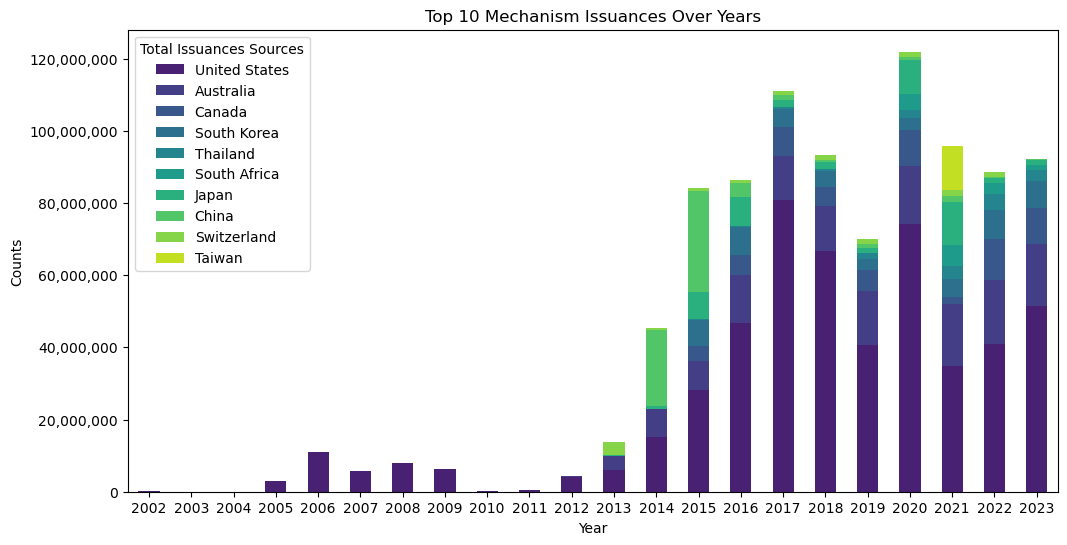

In [18]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

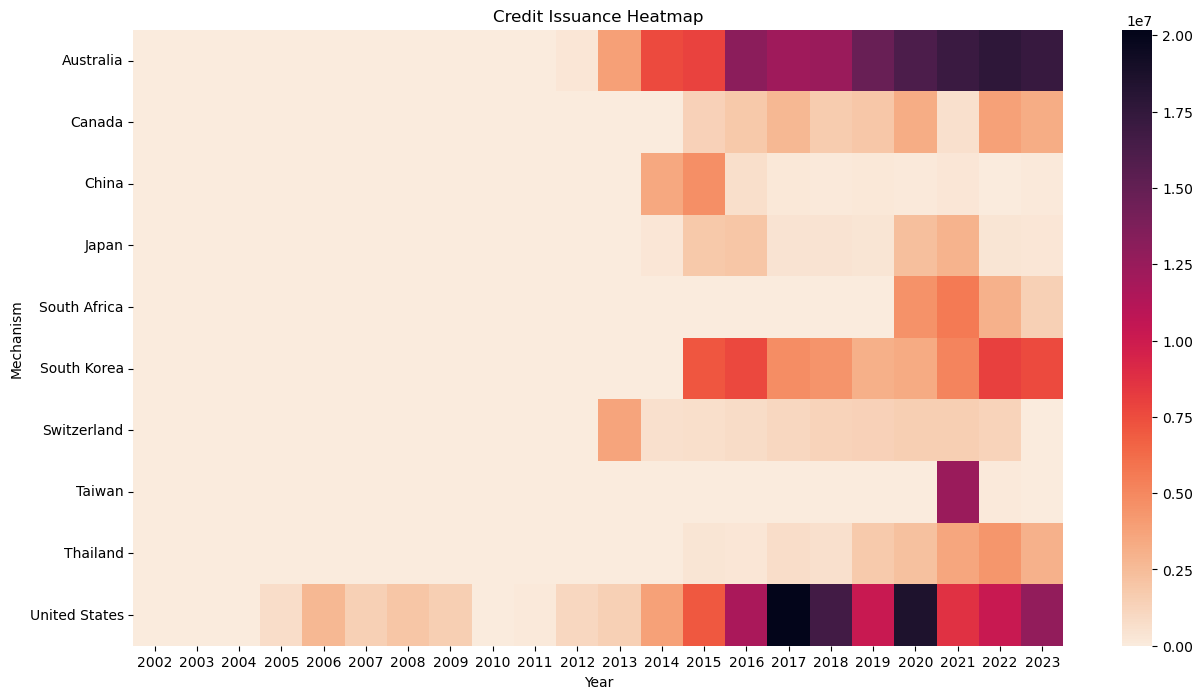

In [19]:
# 將數據按照年份和機制進行重塑，以便用於繪製熱度圖

heatmap_data = ts_top.pivot_table(index='country', columns='Year', values='value')

plt.figure(figsize=(15, 8))

# 繪製熱度圖，設置顏色的透明度
sns.heatmap(heatmap_data, cmap='rocket_r')

# 添加標題和標籤
plt.title('Credit Issuance Heatmap')
plt.xlabel('Year')
plt.ylabel('Mechanism')
plt.xticks(rotation=0)

plt.show()

---

### 用單一機制看成長

In [20]:
ts_total_value = ts.groupby('Mechanism')['value'].sum()
ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

Mechanism
Clean Development Mechanism                       2.431808e+09
Verified Carbon Standard                          1.185281e+09
Joint Implementation                              8.718936e+08
American Carbon Registry                          2.678596e+08
Gold Standard                                     2.627529e+08
California Compliance Offset Program              2.569119e+08
Climate Action Reserve                            1.984872e+08
Australian Carbon Credit Unit Scheme (ACCU)       1.403000e+08
China GHG Voluntary Emission Reduction Program    5.300000e+07
Republic of Korea Offset Credit Mechanism         5.132988e+07
Name: value, dtype: float64

In [21]:
ts_top = ts[ts['Mechanism'].isin(['Clean Development Mechanism', 'Verified Carbon Standard',  'Joint Implementation','American Carbon Registry', 
                                  'Gold Standard', 'California Compliance Offset Program', 'Climate Action Reserve', 'Australian Carbon Credit Unit Scheme',  
                                  'China GHG Voluntary Emission Reduction Program', 'Republic of Korea Offset Credit Mechanism'])]
    
ts_top

,country,Mechanism,Year,value
1,United States,American Carbon Registry,2002,125000.0
6,United States,California Compliance Offset Program,2002,0.0
8,China,China GHG Voluntary Emission Reduction Program,2002,0.0
10,None,Clean Development Mechanism,2002,0.0
11,None,Climate Action Reserve,2002,0.0
...,...,...,...,...
788,None,Climate Action Reserve,2023,13470477.0
791,None,Gold Standard,2023,60811859.0
795,None,Joint Implementation,2023,0.0
799,South Korea,Republic of Korea Offset Credit Mechanism,2023,7602711.0


In [22]:
# 使用pivot將數據轉換乘寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Mechanism', values='value', aggfunc='sum').fillna(0)
pivot_ts

Mechanism,American Carbon Registry,California Compliance Offset Program,China GHG Voluntary Emission Reduction Program,Clean Development Mechanism,Climate Action Reserve,Gold Standard,Joint Implementation,Republic of Korea Offset Credit Mechanism,Verified Carbon Standard
Year,,,,,,,,,
2002,125000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,2880358.0,0.0,0.0,103732.0,0.0,0.0,0.0,0.0,0.0
2006,11027146.0,0.0,0.0,25688774.0,0.0,0.0,0.0,0.0,0.0
2007,5847510.0,0.0,0.0,76688338.0,0.0,0.0,0.0,0.0,0.0
2008,7938812.0,0.0,0.0,137874364.0,426862.0,819181.0,120000.0,0.0,0.0
2009,6245281.0,0.0,0.0,123427031.0,1895410.0,1096855.0,5995089.0,0.0,20731991.0
2010,171069.0,0.0,0.0,132396048.0,7890136.0,2678915.0,30954580.0,0.0,24014316.0


In [23]:
# 取2023年的排序
data_2023 = pivot_ts.loc[2023]

# 獲得2023年數據排序
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Mechanism,Verified Carbon Standard,Clean Development Mechanism,Gold Standard,American Carbon Registry,California Compliance Offset Program,Climate Action Reserve,Republic of Korea Offset Credit Mechanism,China GHG Voluntary Emission Reduction Program,Joint Implementation
Year,,,,,,,,,
2002,0.0,0.0,0.0,125000.0,0.0,0.0,0.0,0.0,0.0
2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0
2005,0.0,103732.0,0.0,2880358.0,0.0,0.0,0.0,0.0,0.0
2006,0.0,25688774.0,0.0,11027146.0,0.0,0.0,0.0,0.0,0.0
2007,0.0,76688338.0,0.0,5847510.0,0.0,0.0,0.0,0.0,0.0
2008,0.0,137874364.0,819181.0,7938812.0,0.0,426862.0,0.0,0.0,120000.0
2009,20731991.0,123427031.0,1096855.0,6245281.0,0.0,1895410.0,0.0,0.0,5995089.0
2010,24014316.0,132396048.0,2678915.0,171069.0,0.0,7890136.0,0.0,0.0,30954580.0


<Figure size 1200x600 with 0 Axes>

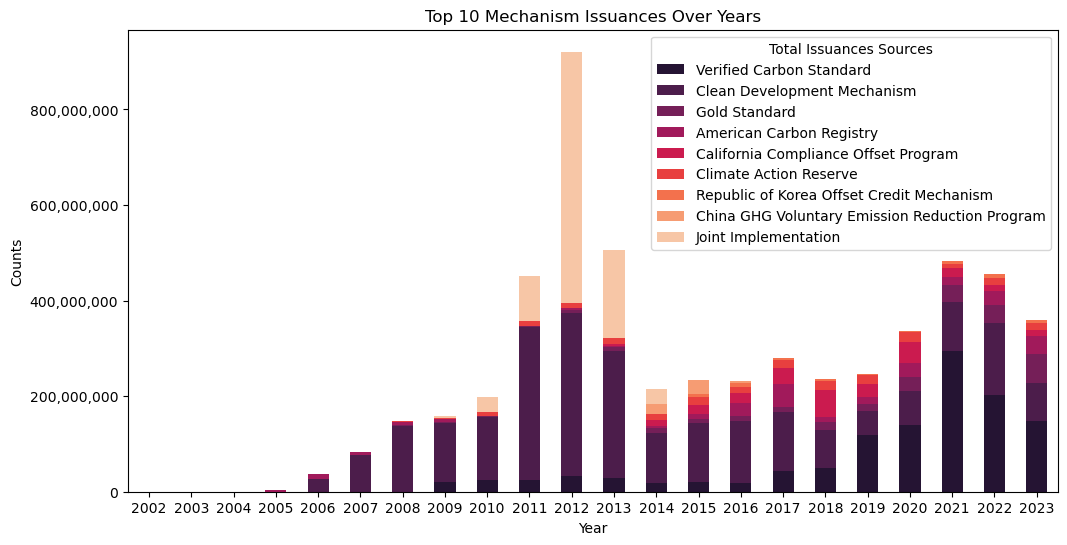

In [24]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

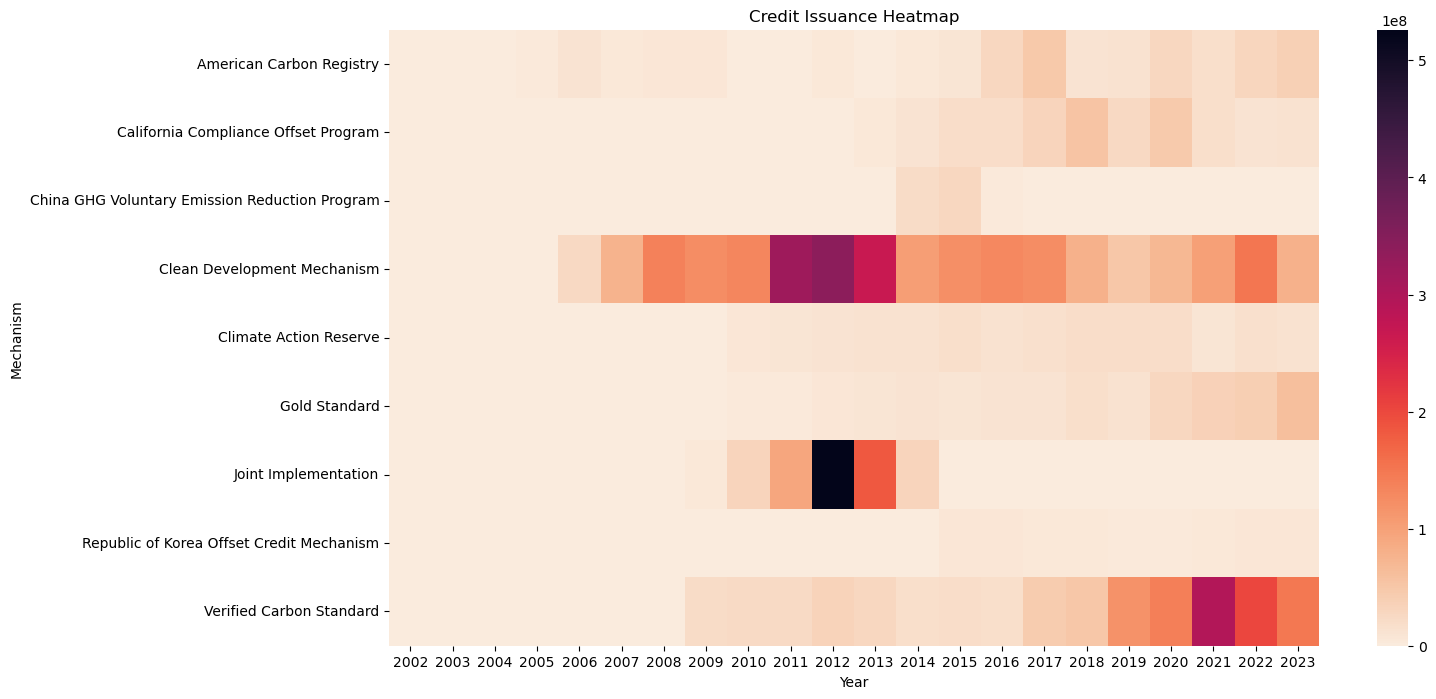

In [25]:
# 將數據按照年份和機制進行重塑，以便用於繪製熱度圖

heatmap_data = ts_top.pivot_table(index='Mechanism', columns='Year', values='value')

plt.figure(figsize=(15, 8))

# 繪製熱度圖，設置顏色的透明度
sns.heatmap(heatmap_data, cmap='rocket_r')

# 添加標題和標籤
plt.title('Credit Issuance Heatmap')
plt.xlabel('Year')
plt.ylabel('Mechanism')
plt.xticks(rotation=0)

plt.show()

---

## 中國crediting市場

In [26]:
df

,Mechanism,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,country
0,Alberta Emission Offset System,-,-,-,-,-,-,-,-,-,...,"4,011,000","4,463,000","5,057,000","4,866,000","3,618,000","8,400,000","393,000","6,400,000","7,799,074",Canada
1,American Carbon Registry,"125,000",-,500,"2,880,358","11,027,146","5,847,510","7,938,812","6,245,281","171,069",...,"8,732,794","27,095,713","47,983,817","12,048,989","14,229,468","28,693,311","17,563,259","29,322,192","37,355,459",United States
2,Australian Carbon Credit Unit Scheme (ACCU),-,-,-,-,-,-,-,-,-,...,"7,900,000","13,100,000","12,200,000","12,400,000","14,800,000","16,100,000","17,100,000","17,700,000","17,200,000",Australia
3,Beijing Forestry Offset Mechanism,-,-,-,-,-,-,-,-,-,...,"45,000","45,000",-,-,-,-,-,-,-,China
4,Beijing Parking Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,"2,128",-,-,China
5,British Columbia Offset Program,-,-,-,-,-,-,-,-,-,...,-,"768,150","3,119,145","205,507","2,107,083","1,356,296","1,210,721","4,835,135","1,930,665",Canada
6,California Compliance Offset Program,-,-,-,-,-,-,-,-,-,...,"19,561,213","19,776,011","32,732,903","54,732,348","26,541,225","45,543,188","17,409,784","11,565,096","13,797,604",United States
7,Chile Green Tax Emissions Offsetting Scheme,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,"258,547",Chile
8,China GHG Voluntary Emission Reduction Program,-,-,-,-,-,-,-,-,-,...,"28,000,000","4,000,000",-,-,-,-,-,-,-,China
9,Chongqing carbon offset mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,"1,200,000","350,000","365,198",China


In [27]:
china_mechanism = [
    'Beijing Forestry Offset Mechanism',
    'Beijing Parking Offset Crediting Mechanism',
#     'China GHG Voluntary Emission Reduction Program', 數值太大導致其他不明顯
    'Chongqing carbon offset mechanism',
    'Fujian Forestry Offset Crediting Mechanism',
    'Guangdong Pu Hui Offset Crediting Mechanism'
]

# Filter the DataFrame
china_df = df[df['Mechanism'].isin(china_mechanism)]

# Select all columns except the 'country' column
china_df = china_df.drop(columns=['country'])

china_df

,Mechanism,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
3,Beijing Forestry Offset Mechanism,-,-,-,-,-,-,-,-,-,...,-,"45,000","45,000",-,-,-,-,-,-,-
4,Beijing Parking Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,"2,128",-,-
9,Chongqing carbon offset mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,"1,200,000","350,000","365,198"
13,Fujian Forestry Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,"1,073,000",-,"767,000","160,000","330,000",-,-
15,Guangdong Pu Hui Offset Crediting Mechanism,-,-,-,-,-,-,-,-,-,...,-,-,-,"242,000","605,000","210,000","600,000","278,000",-,"143,804"


In [28]:
# transpose year
ts_china = china_df.melt(id_vars=['Mechanism'], var_name='Year')
ts_china

,Mechanism,Year,value
0,Beijing Forestry Offset Mechanism,2002,-
1,Beijing Parking Offset Crediting Mechanism,2002,-
2,Chongqing carbon offset mechanism,2002,-
3,Fujian Forestry Offset Crediting Mechanism,2002,-
4,Guangdong Pu Hui Offset Crediting Mechanism,2002,-
...,...,...,...
105,Beijing Forestry Offset Mechanism,2023,-
106,Beijing Parking Offset Crediting Mechanism,2023,-
107,Chongqing carbon offset mechanism,2023,"365,198"
108,Fujian Forestry Offset Crediting Mechanism,2023,-


In [29]:
ts_china['Year'] = pd.to_datetime(ts_china['Year'], format='%Y')
ts_china

,Mechanism,Year,value
0,Beijing Forestry Offset Mechanism,2002-01-01,-
1,Beijing Parking Offset Crediting Mechanism,2002-01-01,-
2,Chongqing carbon offset mechanism,2002-01-01,-
3,Fujian Forestry Offset Crediting Mechanism,2002-01-01,-
4,Guangdong Pu Hui Offset Crediting Mechanism,2002-01-01,-
...,...,...,...
105,Beijing Forestry Offset Mechanism,2023-01-01,-
106,Beijing Parking Offset Crediting Mechanism,2023-01-01,-
107,Chongqing carbon offset mechanism,2023-01-01,"365,198"
108,Fujian Forestry Offset Crediting Mechanism,2023-01-01,-


In [30]:
ts_china['value'] = ts_china['value'].str.replace(',', '')
ts_china['value'] = pd.to_numeric(ts_china['value'], errors='coerce')
# ts.dropna(subset=['value'], inplace=True)
ts_china

,Mechanism,Year,value
0,Beijing Forestry Offset Mechanism,2002-01-01,NaN
1,Beijing Parking Offset Crediting Mechanism,2002-01-01,NaN
2,Chongqing carbon offset mechanism,2002-01-01,NaN
3,Fujian Forestry Offset Crediting Mechanism,2002-01-01,NaN
4,Guangdong Pu Hui Offset Crediting Mechanism,2002-01-01,NaN
...,...,...,...
105,Beijing Forestry Offset Mechanism,2023-01-01,NaN
106,Beijing Parking Offset Crediting Mechanism,2023-01-01,NaN
107,Chongqing carbon offset mechanism,2023-01-01,365198.0
108,Fujian Forestry Offset Crediting Mechanism,2023-01-01,NaN


In [31]:
ts_china['value'].fillna(0, inplace=True)
ts_china

,Mechanism,Year,value
0,Beijing Forestry Offset Mechanism,2002-01-01,0.0
1,Beijing Parking Offset Crediting Mechanism,2002-01-01,0.0
2,Chongqing carbon offset mechanism,2002-01-01,0.0
3,Fujian Forestry Offset Crediting Mechanism,2002-01-01,0.0
4,Guangdong Pu Hui Offset Crediting Mechanism,2002-01-01,0.0
...,...,...,...
105,Beijing Forestry Offset Mechanism,2023-01-01,0.0
106,Beijing Parking Offset Crediting Mechanism,2023-01-01,0.0
107,Chongqing carbon offset mechanism,2023-01-01,365198.0
108,Fujian Forestry Offset Crediting Mechanism,2023-01-01,0.0


In [32]:
ts_china['value'] = pd.to_numeric(ts_china['value'], errors='coerce')
ts_china['Year'] = ts_china['Year'].dt.year

ts_china

,Mechanism,Year,value
0,Beijing Forestry Offset Mechanism,2002,0.0
1,Beijing Parking Offset Crediting Mechanism,2002,0.0
2,Chongqing carbon offset mechanism,2002,0.0
3,Fujian Forestry Offset Crediting Mechanism,2002,0.0
4,Guangdong Pu Hui Offset Crediting Mechanism,2002,0.0
...,...,...,...
105,Beijing Forestry Offset Mechanism,2023,0.0
106,Beijing Parking Offset Crediting Mechanism,2023,0.0
107,Chongqing carbon offset mechanism,2023,365198.0
108,Fujian Forestry Offset Crediting Mechanism,2023,0.0


In [33]:
pivot = ts_china.pivot_table(index='Year', columns='Mechanism', values='value', aggfunc='sum').fillna(0)

pivot

Mechanism,Beijing Forestry Offset Mechanism,Beijing Parking Offset Crediting Mechanism,Chongqing carbon offset mechanism,Fujian Forestry Offset Crediting Mechanism,Guangdong Pu Hui Offset Crediting Mechanism
Year,,,,,
2002,0.0,0.0,0.0,0.0,0.0
2003,0.0,0.0,0.0,0.0,0.0
2004,0.0,0.0,0.0,0.0,0.0
2005,0.0,0.0,0.0,0.0,0.0
2006,0.0,0.0,0.0,0.0,0.0
2007,0.0,0.0,0.0,0.0,0.0
2008,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0


<Figure size 1200x600 with 0 Axes>

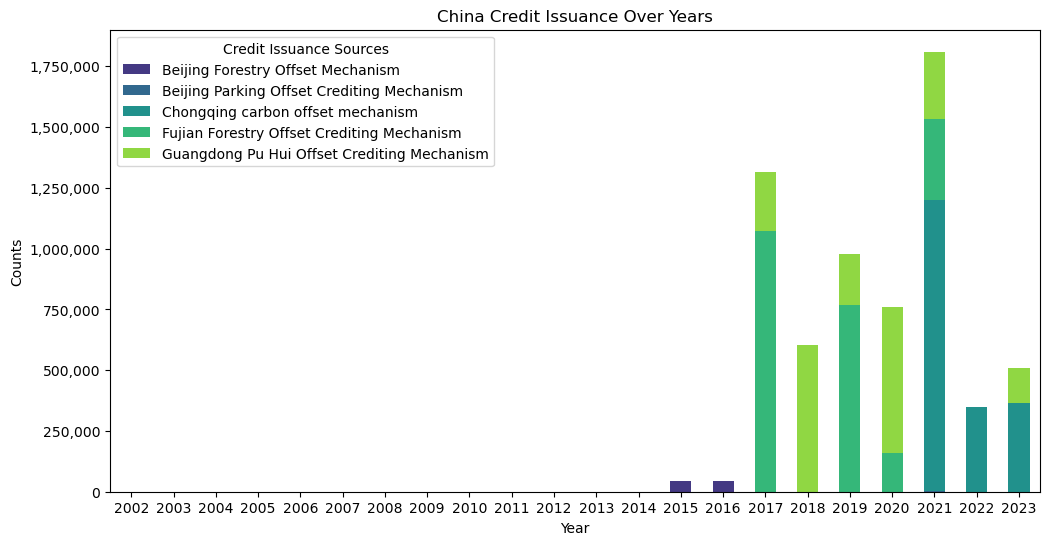

In [34]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(pivot.columns))

ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('China Credit Issuance Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Credit Issuance Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

<Figure size 1200x600 with 0 Axes>

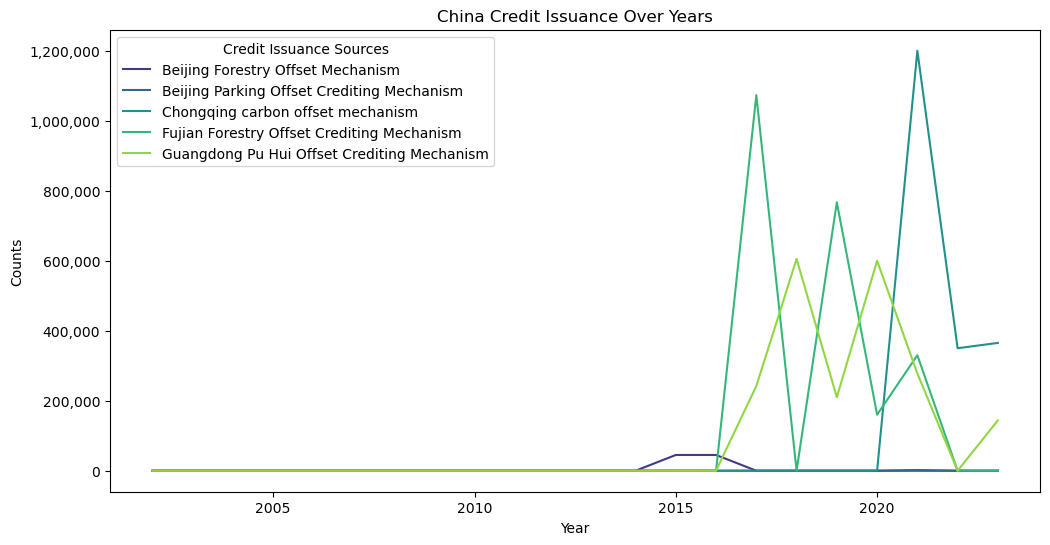

In [35]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(pivot.columns))

ax = pivot.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('China Credit Issuance Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Credit Issuance Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

## 台灣綠電憑證市場

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
columns = ['Source', 'Buyer', 'C_Type', 'E_Type', 'num']

df = pd.read_csv('certificate_supply.csv', usecols=columns)
df

,Source,Buyer,C_Type,E_Type,num
0,中威風力發電股份有限公司\n(台中風場),台灣積體電路製造股份有限公司,風力能,轉供,61501
1,中租電力科技股份有限公司\n(帝寶工業新營廠房屋頂太陽光電發電廠),中租迪和股份有限公司,太陽能,轉供,270
2,中鋼光能股份有限公司\n(中鋼成品倉庫07庫&條線工場08庫),中國鋼鐵股份有限公司,太陽能,併網型直供,871
3,中鋼光能股份有限公司\n(中鋼鋼板工場#02#03庫),中國鋼鐵股份有限公司,太陽能,併網型直供,632
4,中鋼光能股份有限公司\n(中鋼#09~#11條鋼工廠),中國鋼鐵股份有限公司,太陽能,併網型直供,457
...,...,...,...,...,...
736,鹿威風力發電股份有限公司\n(鹿威-鹿港風場),台灣積體電路製造股份有限公司,風力能,轉供,43073
737,鹿威風力發電股份有限公司\n(鹿港風場二期),台灣積體電路製造股份有限公司,風力能,轉供,6610
738,龍威風力發電股份有限公司\n(龍威風場一),台灣積體電路製造股份有限公司,風力能,轉供,30164
739,龍威風力發電股份有限公司\n(龍威風場二),台灣積體電路製造股份有限公司,風力能,轉供,3784


In [3]:
df[['Suppler', 'Source']] = df['Source'].str.split('\n', expand=True)

df

,Source,Buyer,C_Type,E_Type,num,Suppler
0,(台中風場),台灣積體電路製造股份有限公司,風力能,轉供,61501,中威風力發電股份有限公司
1,(帝寶工業新營廠房屋頂太陽光電發電廠),中租迪和股份有限公司,太陽能,轉供,270,中租電力科技股份有限公司
2,(中鋼成品倉庫07庫&條線工場08庫),中國鋼鐵股份有限公司,太陽能,併網型直供,871,中鋼光能股份有限公司
3,(中鋼鋼板工場#02#03庫),中國鋼鐵股份有限公司,太陽能,併網型直供,632,中鋼光能股份有限公司
4,(中鋼#09~#11條鋼工廠),中國鋼鐵股份有限公司,太陽能,併網型直供,457,中鋼光能股份有限公司
...,...,...,...,...,...,...
736,(鹿威-鹿港風場),台灣積體電路製造股份有限公司,風力能,轉供,43073,鹿威風力發電股份有限公司
737,(鹿港風場二期),台灣積體電路製造股份有限公司,風力能,轉供,6610,鹿威風力發電股份有限公司
738,(龍威風場一),台灣積體電路製造股份有限公司,風力能,轉供,30164,龍威風力發電股份有限公司
739,(龍威風場二),台灣積體電路製造股份有限公司,風力能,轉供,3784,龍威風力發電股份有限公司


In [4]:
total_num_by_buyer = df.groupby('Buyer')['num'].sum()

total_sum = total_num_by_buyer.sum()
print(f'Total num by all buyers: {total_sum:,.0f}')

max_buyer = total_num_by_buyer.idxmax()
max_num = total_num_by_buyer.max()
print(f'Maximum num by a buyer: {max_buyer}, {max_num:,.0f}')

no_tsmc_num = total_sum - max_num
print(f'Total num without TSMC: {no_tsmc_num:,.0f}')

Total num by all buyers: 963,928
Maximum num by a buyer: 台灣積體電路製造股份有限公司, 557,160
Total num without TSMC: 406,768


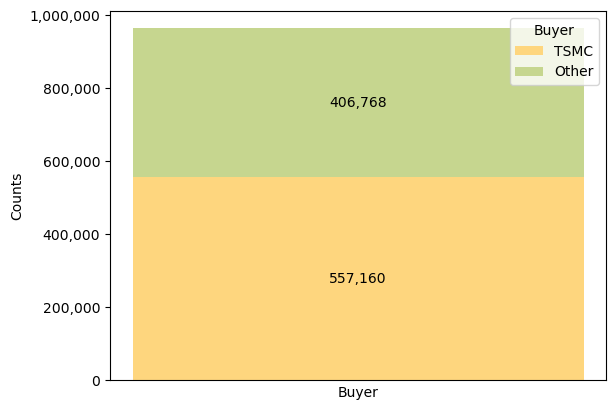

In [5]:
# Create the data
data = {'num': [557160, 406768], 'buyer': ['TSMC', 'Other']}
df_tsmc = pd.DataFrame(data)

# Plotting the stacked bar chart
fig, ax = plt.subplots()

# Define colors for the bars
colors = ['#FED67E', '#C6D68F']

# Plot the bars
bar_width = 0.3
bottom = 0

for num, buyer, color in zip(df_tsmc['num'], df_tsmc['buyer'], colors):
    ax.bar('Counts', num, bar_width, bottom=bottom, label=buyer, color=color)
    bottom += num

# Adding text labels with formatted numbers
bottom = 0
for num in df_tsmc['num']:
    ax.text('Counts', bottom + num / 2, f'{num:,}', ha='center', va='center')
    bottom += num

# Adding title and labels
ax.set_xlabel('Buyer')
ax.set_ylabel('Counts')

# Reorder the legend
ax.legend(title='Buyer', labels=['TSMC', 'Other'])

# Remove x-ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Function to format y-axis labels as real numbers
def format_func(value, tick_number):
    return f"{value:,.0f}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

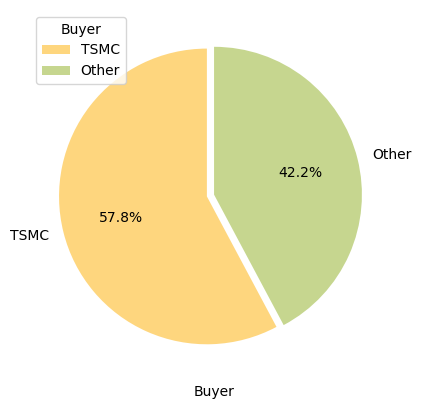

In [6]:
data = {'num': [557160, 406768], 'buyer': ['TSMC', 'Other']}
df_tsmc = pd.DataFrame(data)

# Define colors for the pie chart
colors = ['#FED67E', '#C6D68F']

# Define explode (offset) values
explode = [0.05 if buyer == 'TSMC' else 0 for buyer in df_tsmc['buyer']]

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(df_tsmc['num'], labels=df_tsmc['buyer'], colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

# Adding title and labels
ax.set_xlabel('Buyer')
ax.set_ylabel('')

# Reorder the legend
ax.legend(title='Buyer', labels=['TSMC', 'Other'], loc='upper left')

plt.show()


In [7]:
# 按 'Buyer' 分組，計算每個 'Buyer' 的 'num' 總和
buyer_total_num = df.groupby('Buyer')['num'].sum()

top10_buyers = buyer_total_num.nlargest(10)
top10_buyers

Buyer
台灣積體電路製造股份有限公司       557160
台達電子工業股份有限公司          52502
友達光電股份有限公司            17330
聯華電子股份有限公司            16075
高雄晶傑達光電科技股份有限公司       15501
南亞科技股份有限公司            13657
中國鋼鐵股份有限公司            12342
中華電信股份有限公司資訊技術分公司     12191
東和鋼鐵企業股份有限公司          10388
采鈺科技股份有限公司             9857
Name: num, dtype: int64

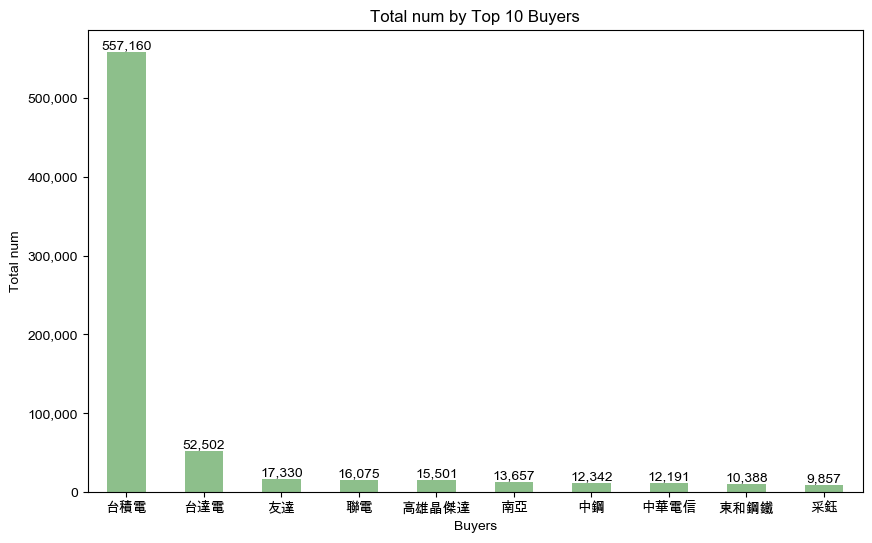

In [8]:
top10_buyers = top10_buyers.sort_values(ascending=False)

# 顯示中文
plt.rcParams['font.family'] = 'Arial Unicode MS'

top10_buyers.rename(index={'台灣積體電路製造股份有限公司': '台積電', '台達電子工業股份有限公司': '台達電', '友達光電股份有限公司': '友達', '聯華電子股份有限公司': '聯電', '高雄晶傑達光電科技股份有限公司': '高雄晶傑達',
                    '南亞科技股份有限公司': '南亞', '中國鋼鐵股份有限公司': '中鋼', '中華電信股份有限公司資訊技術分公司': '中華電信', '東和鋼鐵企業股份有限公司': '東和鋼鐵', '采鈺科技股份有限公司': '采鈺'}, inplace=True)


plt.figure(figsize=(10, 6))
ax = top10_buyers.plot(kind='bar', color=['#8dbf8b']) #, #3F7C88
plt.title('Total num by Top 10 Buyers')
plt.xlabel('Buyers')
plt.ylabel('Total num')
plt.xticks(rotation=0)

for i, v in enumerate(top10_buyers):
    ax.text(i, v + 0.1, f'{v:,.0f}', ha='center', va='bottom')

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


plt.show()

In [9]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2024 = pd.read_csv('certificate_2024.csv', usecols=columns)
df_2024

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2024,17675,12777
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2024,21329,1699
2,創維風力發電股份有限公司\n創維風場,2024,33358,0
3,觀威風力發電股份有限公司\n觀音風力發電廠,2024,20601,0
4,台汽電綠能股份有限公司\n大鵬風力發電廠,2024,13440,3589
...,...,...,...,...
716,台汽電綠能股份有限公司\n烏山頭水力發電廠,2024,5142,0
717,台灣化學纖維股份有限公司\n台灣化學纖維股份有限公司蘭潭管小水電,2024,0,84
718,農業部農村發展及水土保持署臺北分署\n崩山湖微水力發電站,2024,0,1
719,台灣綠氫股份有限公司\n台灣綠氫_餘氫再生系統,2024,0,0


In [10]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2023 = pd.read_csv('certificate_2023.csv', usecols=columns)
df_2023

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2023,135422,0
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2023,104187,0
2,創維風力發電股份有限公司\n創維風場,2023,97827,0
3,觀威風力發電股份有限公司\n觀音風力發電廠,2023,86895,0
4,台汽電綠能股份有限公司\n大鵬風力發電廠,2023,76642,0
...,...,...,...,...
658,花蓮綠能股份有限公司\n名間電力股份有限公司 水力發電廠,2023,41119,0
659,嘉南實業股份有限公司\n西口水力發電廠,2023,10298,0
660,台汽電綠能股份有限公司\n烏山頭水力發電廠,2023,5721,0
661,台灣綠氫股份有限公司\n台灣綠氫_餘氫再生系統,2023,0,2


In [11]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2022 = pd.read_csv('certificate_2022.csv', usecols=columns)
df_2022

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2022,148674,0
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2022,137923,0
2,創維風力發電股份有限公司\n創維風場,2022,21094,0
3,觀威風力發電股份有限公司\n觀音風力發電廠,2022,54106,0
4,台汽電綠能股份有限公司\n大鵬風力發電廠,2022,107088,0
...,...,...,...,...
327,台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部四林畜殖場,2022,0,0
328,花蓮綠能股份有限公司\n名間電力股份有限公司 水力發電廠,2022,16134,0
329,嘉南實業股份有限公司\n西口水力發電廠,2022,109,0
330,台汽電綠能股份有限公司\n烏山頭水力發電廠,2022,17886,0


In [12]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2021 = pd.read_csv('certificate_2021.csv', usecols=columns)
df_2021

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2021,130649,0
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2021,103463,0
2,台汽電綠能股份有限公司\n大鵬風力發電廠,2021,84490,0
3,鹿威風力發電股份有限公司\n鹿威-鹿港風場,2021,56382,0
4,通威風力發電股份有限公司\n通威風場一,2021,41208,0
...,...,...,...,...
205,台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠,2021,0,4
206,台灣大哥大股份有限公司\n台灣大哥大股份有限公司,2021,0,4
207,亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司,2021,0,6
208,台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場,2021,27,1


In [13]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2020 = pd.read_csv('certificate_2020.csv', usecols=columns)
df_2020

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2020,32396,0
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2020,33701,0
2,台汽電綠能股份有限公司\n大鵬風力發電廠,2020,31210,0
3,鹿威風力發電股份有限公司\n鹿威-鹿港風場,2020,20852,0
4,通威風力發電股份有限公司\n通威風場一,2020,12130,0
...,...,...,...,...
162,台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠,2020,0,4
163,台灣大哥大股份有限公司\n台灣大哥大股份有限公司,2020,0,6
164,亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司,2020,0,6
165,台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場,2020,44,1


In [14]:
dfs = [df_2024, df_2023, df_2022, df_2021, df_2020]

# Add 'Year' column to each dataframe
for i, df in enumerate(dfs):
    df['Year'] = 2024 - i

# Concatenate the dataframes
df_concat = pd.concat(dfs)
df_concat

,Source,Year,Trans_num,Remaining_num
0,中威風力發電股份有限公司\n台中風場,2024,17675,12777
1,鹿威風力發電股份有限公司\n鹿威-彰濱風場,2024,21329,1699
2,創維風力發電股份有限公司\n創維風場,2024,33358,0
3,觀威風力發電股份有限公司\n觀音風力發電廠,2024,20601,0
4,台汽電綠能股份有限公司\n大鵬風力發電廠,2024,13440,3589
...,...,...,...,...
162,台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠,2020,0,4
163,台灣大哥大股份有限公司\n台灣大哥大股份有限公司,2020,0,6
164,亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司,2020,0,6
165,台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場,2020,44,1


In [15]:
df_concat[['Supplier', 'Source']] = df_concat['Source'].str.split('\n', expand=True)
df_concat

,Source,Year,Trans_num,Remaining_num,Supplier
0,台中風場,2024,17675,12777,中威風力發電股份有限公司
1,鹿威-彰濱風場,2024,21329,1699,鹿威風力發電股份有限公司
2,創維風場,2024,33358,0,創維風力發電股份有限公司
3,觀音風力發電廠,2024,20601,0,觀威風力發電股份有限公司
4,大鵬風力發電廠,2024,13440,3589,台汽電綠能股份有限公司
...,...,...,...,...,...
162,台灣電力股份有限公司第二核能發電廠,2020,0,4,台灣電力股份有限公司第二核能發電廠
163,台灣大哥大股份有限公司,2020,0,6,台灣大哥大股份有限公司
164,亞東工業氣體股份有限公司,2020,0,6,亞東工業氣體股份有限公司
165,台灣糖業股份有限公司畜殖事業部大響營第一畜殖場,2020,44,1,台灣糖業股份有限公司


In [16]:
# Drop the 'Source' column
df_concat.drop(columns=['Source'], inplace=True)

# Sum 'Trans_num' and 'Remaining_num' to create 'Total'
df_concat['Total'] = df_concat['Trans_num'] + df_concat['Remaining_num']

# Drop the 'Trans_num' and 'Remaining_num' columns
df_concat.drop(columns=['Trans_num', 'Remaining_num'], inplace=True)

ts = df_concat.groupby(['Supplier', 'Year']).sum().reset_index()
ts

,Supplier,Year,Total
0,三信商業銀行股份有限公司,2023,6
1,三信商業銀行股份有限公司,2024,3
2,上品王食品股份有限公司,2022,478
3,上品王食品股份有限公司,2023,2880
4,上品王食品股份有限公司,2024,426
...,...,...,...
1101,黑松股份有限公司,2023,121
1102,黑松股份有限公司,2024,0
1103,龍威風力發電股份有限公司,2022,51631
1104,龍威風力發電股份有限公司,2023,72976


In [17]:
ts['Year'] = pd.to_datetime(ts['Year'], format='%Y')
ts

,Supplier,Year,Total
0,三信商業銀行股份有限公司,2023-01-01,6
1,三信商業銀行股份有限公司,2024-01-01,3
2,上品王食品股份有限公司,2022-01-01,478
3,上品王食品股份有限公司,2023-01-01,2880
4,上品王食品股份有限公司,2024-01-01,426
...,...,...,...
1101,黑松股份有限公司,2023-01-01,121
1102,黑松股份有限公司,2024-01-01,0
1103,龍威風力發電股份有限公司,2022-01-01,51631
1104,龍威風力發電股份有限公司,2023-01-01,72976


In [18]:
ts['Total'].dtype

dtype('int64')

In [19]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Supplier  1106 non-null   object        
 1   Year      1106 non-null   datetime64[ns]
 2   Total     1106 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 26.1+ KB


In [20]:
# 將年份從日期中提取出來
ts['Year'] = ts['Year'].dt.year #跑第二次要先c/
ts

,Supplier,Year,Total
0,三信商業銀行股份有限公司,2023,6
1,三信商業銀行股份有限公司,2024,3
2,上品王食品股份有限公司,2022,478
3,上品王食品股份有限公司,2023,2880
4,上品王食品股份有限公司,2024,426
...,...,...,...
1101,黑松股份有限公司,2023,121
1102,黑松股份有限公司,2024,0
1103,龍威風力發電股份有限公司,2022,51631
1104,龍威風力發電股份有限公司,2023,72976


In [21]:
ts_sum = ts.groupby(['Year', 'Supplier'])['Total'].sum().reset_index()
ts_sum

,Year,Supplier,Total
0,2020,中國信託商業銀行(股)公司,63
1,2020,中威風力發電股份有限公司,32396
2,2020,中華航空股份有限公司,117
3,2020,中華郵政股份有限公司,25
4,2020,中華電信股份有限公司資訊技術分公司,105
...,...,...,...
1101,2024,高雄市那瑪夏區民權國民小學,4
1102,2024,鹿威風力發電股份有限公司,45232
1103,2024,麥箖企業股份有限公司,27
1104,2024,黑松股份有限公司,0


In [22]:
ts_total_value = ts_sum.groupby('Supplier')['Total'].sum()

ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

Supplier
鹿威風力發電股份有限公司      674319
台汽電綠能股份有限公司       489059
中威風力發電股份有限公司      477593
台灣艾貴太陽能源股份有限公司    407520
通威風力發電股份有限公司      268906
富威電力股份有限公司        227829
觀威風力發電股份有限公司      161602
創維風力發電股份有限公司      152279
龍威風力發電股份有限公司      142675
中華紙漿股份有限公司        136395
Name: Total, dtype: int64

In [23]:
ts_top = ts_sum[ts_sum['Supplier'].isin(['鹿威風力發電股份有限公司', '台汽電綠能股份有限公司', '中威風力發電股份有限公司', '台灣艾貴太陽能源股份有限公司','通威風力發電股份有限公司', 
                                 '富威電力股份有限公司', '觀威風力發電股份有限公司', '創維風力發電股份有限公司', '龍威風力發電股份有限公司','中華紙漿股份有限公司'
    
])]
    
ts_top

,Year,Supplier,Total
1,2020,中威風力發電股份有限公司,32396
19,2020,台汽電綠能股份有限公司,37438
32,2020,台灣艾貴太陽能源股份有限公司,73479
60,2020,富威電力股份有限公司,143
97,2020,通威風力發電股份有限公司,20355
100,2020,鹿威風力發電股份有限公司,58009
103,2021,中威風力發電股份有限公司,130649
127,2021,台汽電綠能股份有限公司,109335
141,2021,台灣艾貴太陽能源股份有限公司,109850
171,2021,富威電力股份有限公司,8486


In [24]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Supplier', values='Total')
pivot_ts.fillna(0, inplace=True)
pivot_ts

Supplier,中威風力發電股份有限公司,中華紙漿股份有限公司,創維風力發電股份有限公司,台汽電綠能股份有限公司,台灣艾貴太陽能源股份有限公司,富威電力股份有限公司,觀威風力發電股份有限公司,通威風力發電股份有限公司,鹿威風力發電股份有限公司,龍威風力發電股份有限公司
Year,,,,,,,,,,
2020,32396.0,0.0,0.0,37438.0,73479.0,143.0,0.0,20355.0,58009.0,0.0
2021,130649.0,0.0,0.0,109335.0,109850.0,8486.0,0.0,73986.0,171194.0,0.0
2022,148674.0,0.0,21094.0,173716.0,106112.0,67147.0,54106.0,86031.0,216025.0,51631.0
2023,135422.0,115789.0,97827.0,137482.0,104590.0,128274.0,86895.0,72644.0,183859.0,72976.0
2024,30452.0,20606.0,33358.0,31088.0,13489.0,23779.0,20601.0,15890.0,45232.0,18068.0


In [25]:
# 取2024年的排序
data_2024 = pivot_ts.loc[2024]

# 獲得2024年數據排序
sorted_columns = data_2024.sort_values(ascending=False).index

# 重新排列 pivot_ts_top DataFrame 的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Supplier,鹿威風力發電股份有限公司,創維風力發電股份有限公司,台汽電綠能股份有限公司,中威風力發電股份有限公司,富威電力股份有限公司,中華紙漿股份有限公司,觀威風力發電股份有限公司,龍威風力發電股份有限公司,通威風力發電股份有限公司,台灣艾貴太陽能源股份有限公司
Year,,,,,,,,,,
2020,58009.0,0.0,37438.0,32396.0,143.0,0.0,0.0,0.0,20355.0,73479.0
2021,171194.0,0.0,109335.0,130649.0,8486.0,0.0,0.0,0.0,73986.0,109850.0
2022,216025.0,21094.0,173716.0,148674.0,67147.0,0.0,54106.0,51631.0,86031.0,106112.0
2023,183859.0,97827.0,137482.0,135422.0,128274.0,115789.0,86895.0,72976.0,72644.0,104590.0
2024,45232.0,33358.0,31088.0,30452.0,23779.0,20606.0,20601.0,18068.0,15890.0,13489.0


<Figure size 1200x600 with 0 Axes>

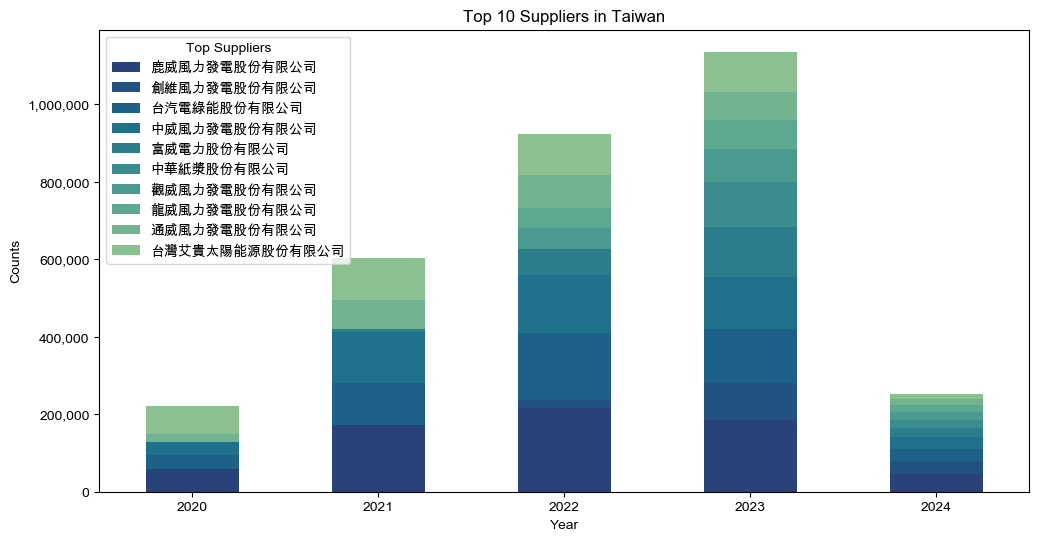

In [26]:
plt.figure(figsize=(12, 6))

# 顯示中文
plt.rcParams['font.family'] = 'Arial Unicode MS'

colors = sns.color_palette('crest_r', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Suppliers in Taiwan')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Top Suppliers')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()